In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import os
import pyreadr
import seaborn as sns
from sklearn.preprocessing import normalize
import igraph as ig
PATH = '../../Data/Data/'

In [2]:
id_col = pd.read_csv(PATH + 'icd_colors.csv', index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: '../../Data/Data/icd_colors.csv'

In [3]:
letter_to_hex = {row['Letter']: hex_code for hex_code, row in id_col.iterrows()}

In [4]:
icd_10_diag_all = pd.read_csv('./../../Comorbidity-Networks-From-Population-Wide-Health-Data/ICD10_Diagnoses_All.csv')

In [5]:
label_all_code = list(icd_10_diag_all['icd_code'])

In [6]:
len(label_all_code)

1080

In [7]:
prev = pd.read_excel(PATH + 'Prevalence_Sex_Age_ICD.xlsx', index_col=0)

In [8]:
mort_m = pd.read_csv(PATH + 'mortality_diag_Male.csv', index_col=0)
mort_f = pd.read_csv(PATH + 'mortality_diag_Female.csv', index_col=0)

In [9]:
mort_M = np.zeros((8,1080))
mort_F = np.zeros((8,1080))

for i in range(8):
    for j in range(1080):
        n_i = i
        n_j = j
        i+1
        val = mort_m.loc[(mort_m['age_10'] == i) & (mort_m['icd_code'] == label_all_code[j]), 'mortality'].values
        val_f = mort_f.loc[(mort_f['age_10'] == i) & (mort_f['icd_code'] == label_all_code[j]), 'mortality'].values
        if len(val_f) > 0:
            mort_F[n_i, n_j] = val_f[0]
        else:
            mort_F[n_i, n_j] = 0.0
        if len(val) > 0:
            mort_M[n_i, n_j] = val[0]
        else:
            mort_M[n_i, n_j] = 0.0
        # prev_m[c, :] = prev.loc[(prev.index == 'Male') & (prev['Age_Group'] == i), 'p'].values

        

## Age and Sex Analysis

In [10]:
number_of_rows = 16
properties = pd.DataFrame({
    'Age': list(range(1, 9)) * 2,
    'sex': [None] * number_of_rows,
    'nodes': [None] * number_of_rows,
    'degree': [None] * number_of_rows,
    'avg_path_length': [None] * number_of_rows,
    'betweenness': [None] * number_of_rows,
    'cen_ftrality': [None] * number_of_rows,
    'closeness': [None] * number_of_rows,
    'density': [None] * number_of_rows,
    'modularity': [None] * number_of_rows
    
})

In [11]:
def normalize_matrix(OR_mat):
    # Loop over each row and normalize by row sums, avoiding division by zero
    for i in range(OR_mat.shape[0]):
        row_sum = OR_mat[i, :].sum()
        if row_sum > 0:
            OR_mat[i, :] = OR_mat[i, :] / row_sum
    return OR_mat

In [75]:
import pyreadr
OR_normalized_f = np.zeros((8, 1080, 1080))
OR_normalized_m = np.zeros((8, 1080, 1080))

ii=0
for age in range(1, 9):
    # Load adjacen_fcy matrix for males
    result_f = pyreadr.read_r(PATH+f"3.AdjacencyMatrices/Adj_Matrix_Female_ICD_age_{age}.rds")
    result_m = pyreadr.read_r(PATH+f"3.AdjacencyMatrices/Adj_Matrix_Male_ICD_age_{age}.rds")
    OR_m = result_m[None].values
    OR_f = result_f[None].values

    # Normalize adjacen_fcy matrix using the R-like method
    OR_normalized_f[age-1,:,:] =  normalize_matrix(OR_f.copy())
    
    # Normalize adjacen_fcy matrix using the R-like method
    OR_normalized_m[age-1,:,:] =  normalize_matrix(OR_m.copy())



In [76]:
cen_f =  np.zeros((1080, 8))
for i in range(8):

    cen_f[:, i] = np.sum(OR_normalized_f[i, :, :], axis=0)

cen_degree_f = np.zeros((1080, 8))
for i in range(8):
    cen_degree_f[:, i] = np.sum(np.where(OR_normalized_f[i, :, :]>0, 1, 0), axis=1)
cen_m =  np.zeros((1080, 8))
for i in range(8):
    cen_m[:, i] = np.sum(OR_normalized_m[i, :, :], axis=0)

cen_degree_m = np.zeros((1080, 8))
for i in range(8):
    cen_degree_m[:, i] = np.sum(np.where(OR_normalized_m[i, :, :]>0, 1, 0), axis=1)

In [78]:
import csv

with open('cen_m_mortM_by_age.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['cen_m', 'mort_M', 'age_group_index'])
    for i in range(8):
        for j in range(cen_m.shape[0]):
            writer.writerow([cen_m[j, i], mort_M[i, j], i])

In [79]:
mask_zeros_cen_f = np.where(cen_f.sum(1) > 0)[0]
mask_zeros_mort_F = np.where(mort_F.sum(0) != 0)[0]

In [18]:
age_groups = ['0-9', '10-19',  '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
prev_f = np.zeros((8, 1080))
prev_m = np.zeros((8, 1080))

for n_i, i in enumerate(age_groups):
    print(i)
    for n_j, j in enumerate(label_all_code):
        # Select the 'p' values where 'sex' is 'Female' and 'Age_Group' matches i
        val = prev.loc[(prev.index == 'Female') & (prev['Age_Group'] == i) & (prev['icd_code'] == j), 'p'].values
        val_m = prev.loc[(prev.index == 'Male') & (prev['Age_Group'] == i) & (prev['icd_code'] == j), 'p'].values
        if len(val_m) > 0:
            prev_m[n_i, n_j] = val_m[0]
        else:
            prev_m[n_i, n_j] = 0.0
        if len(val) > 0:
            prev_f[n_i, n_j] = val[0]
        else:
            prev_f[n_i, n_j] = 0.0
        # prev_m[c, :] = prev.loc[(prev.index == 'Male') & (prev['Age_Group'] == i), 'p'].values


0-9
10-19
20-29
30-39
40-49
50-59
60-69
70-79


In [80]:
cen_f.sum()

np.float64(1947.0)

In [81]:
# Create a label list with all the labels where cen_f.sum(1) > 0, from label_all_code
labels_nonzero_cen_f = [label_all_code[i] for i in range(len(label_all_code)) if cen_f.sum(axis=1)[i] > 0]
labels_nonzero_cen_m = [label_all_code[i] for i in range(len(label_all_code)) if cen_m.sum(axis=1)[i] > 0]
labels_nonzero_prev_f = [label_all_code[i] for i in range(len(label_all_code)) if prev_f.sum(axis=0)[i] > 0]
labels_nonzero_prev_m = [label_all_code[i] for i in range(len(label_all_code)) if prev_m.sum(axis=0)[i] > 0]
labels_nonzero_mort_F = [label_all_code[i] for i in range(len(label_all_code)) if mort_F.sum(axis=0)[i] != 0]   
labels_nonzero_mort_M = [label_all_code[i] for i in range(len(label_all_code)) if mort_M.sum(axis=0)[i] != 0]

indx_nonzero_cen_f = [i for i in range(len(label_all_code)) if cen_f.sum(axis=1)[i] > 0]
indx_nonzero_cen_m = [i for i in range(len(label_all_code)) if cen_m.sum(axis=1)[i] > 0]
indx_nonzero_prev_f = [i for i in range(len(label_all_code)) if prev_f.sum(axis=0)[i] > 0]
indx_nonzero_prev_m = [i for i in range(len(label_all_code)) if prev_m.sum(axis=0)[i] > 0]
indx_nonzero_mort_F = [i for i in range(len(label_all_code)) if mort_F.sum(axis=0)[i] != 0]
indx_nonzero_mort_M = [i for i in range(len(label_all_code)) if mort_M.sum(axis=0)[i] != 0]

In [82]:
mort_inf_f = np.zeros((1080, 8))
mort_inf_m = np.zeros((1080, 8))

mort_inf_degree_f = np.zeros((1080, 8))
mort_inf_degree_m = np.zeros((1080, 8))

# Calculate the mortality influence

for i in range(8):
    mult_matrix = OR_normalized[i, :, :] * mort_F[i, :, np.newaxis]
    mult_matrix_degree = np.where(OR_normalized[i, :, :] > 0, 1, 0) * mort_F[i, :, np.newaxis]
    mort_inf_degree_f[:, i] = (mult_matrix_degree - np.diag(np.diag(mult_matrix_degree))).sum(axis=0)
    mort_inf_f[:, i] = (mult_matrix - np.diag(np.diag(mult_matrix))).sum(axis=0)

for i in range(8):
    mult_matrix = OR_normalized_m[i, :, :] * mort_M[i, :, np.newaxis]
    mult_matrix_degree = np.where(OR_normalized_m[i, :, :] > 0, 1, 0) * mort_M[i, :, np.newaxis]
    mort_inf_degree_m[:, i] = (mult_matrix_degree - np.diag(np.diag(mult_matrix_degree))).sum(axis=0)
    mort_inf_m[:, i] = (mult_matrix - np.diag(np.diag(mult_matrix))).sum(axis=0)

In [84]:
cen_betweeness_f = np.zeros((1080, 8))
cen_betweeness_m = np.zeros((1080, 8))

for i in range(8):
    # Compute betweenness cen_ftrality for each node from the weighted adjacen_fcy matrix
    g = ig.Graph.Weighted_Adjacency(OR_normalized_f[i, :, :].tolist(), mode="max", attr="weight")
    betweenness = g.betweenness(weights="weight")
    cen_betweeness_f[:, i] = betweenness
    g_m = ig.Graph.Weighted_Adjacency(OR_normalized_m[i, :, :].tolist(), mode="max", attr="weight")
    betweenness_m = g_m.betweenness(weights="weight")
    cen_betweeness_m[:, i] = betweenness_m

In [85]:
indx_nonzero_cen_f

[2,
 4,
 8,
 9,
 35,
 39,
 41,
 53,
 59,
 87,
 89,
 95,
 99,
 100,
 109,
 112,
 113,
 115,
 169,
 170,
 172,
 189,
 191,
 192,
 193,
 194,
 195,
 198,
 204,
 210,
 211,
 215,
 217,
 220,
 221,
 222,
 223,
 224,
 230,
 233,
 237,
 239,
 243,
 244,
 245,
 246,
 248,
 249,
 251,
 255,
 267,
 268,
 273,
 274,
 278,
 279,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 291,
 292,
 293,
 295,
 296,
 298,
 299,
 300,
 302,
 304,
 305,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 320,
 321,
 322,
 323,
 327,
 328,
 329,
 331,
 334,
 342,
 345,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 358,
 360,
 367,
 380,
 384,
 386,
 391,
 394,
 395,
 400,
 401,
 402,
 406,
 407,
 409,
 412,
 413,
 414,
 415,
 417,
 418,
 419,
 420,
 422,
 423,
 424,
 426,
 427,
 428,
 429,
 430,
 431,
 434,
 436,
 437,
 439,
 440,
 442,
 446,
 447,
 448,
 449,
 452,
 453,
 454,
 455,
 456,
 457,
 458,
 459,
 464,
 466,
 467,
 475,
 481,
 482,
 483,
 484,
 485,
 487,
 488,
 489,
 490,
 491,
 494,
 511,
 512,
 51

(<Figure size 700x600 with 2 Axes>,
 <Axes: title={'center': 'COMORBIDITY NETWORK (Female centrality)'}>)

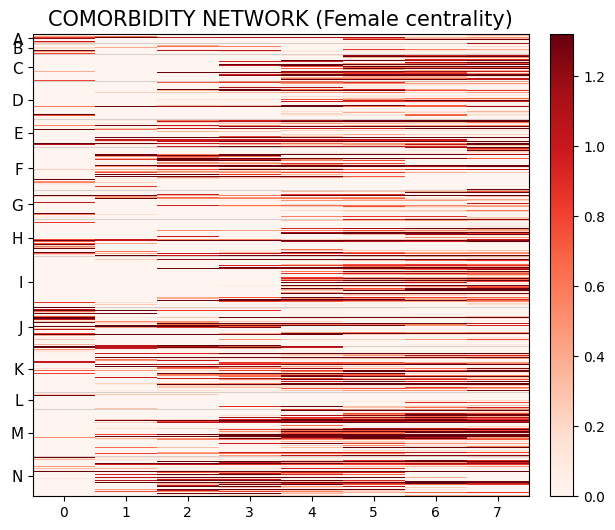

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def imshow_grouped_by_initial(data_array, labels_list, cmap="viridis", title=None):
    X = np.asarray(data_array)
    assert X.ndim == 2 and len(labels_list) == X.shape[0], "Shape mismatch."

    # --- group row indices by first letter ---
    groups = defaultdict(list)
    for i, lab in enumerate(labels_list):
        first = str(lab)[0].upper() if str(lab) else "#"
        groups[first].append(i)

    # sort groups alphabetically by letter
    letters = sorted(groups.keys())

    # --- build row order and group spans ---
    order, spans = [], {}
    start = 0
    for L in letters:
        idxs = groups[L]
        order.extend(idxs)
        spans[L] = (start, start + len(idxs) - 1)
        start += len(idxs)

    X_ord = X[order, :]

    # --- color scale: 10th–90th percentiles ---
    vmin = float(np.percentile(X_ord, 10))
    vmax = float(np.percentile(X_ord, 90))

    # --- plot ---
    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(X_ord, aspect="auto", cmap=cmap, interpolation="nearest",
                   vmin=vmin, vmax=vmax)

    # y-ticks: one per group at its center
    centers = []
    for L in letters:
        a, b = spans[L]
        centers.append((a + b) / 2.0)
    ax.set_yticks(centers)
    ax.set_yticklabels(letters, fontsize=11)

    ax.set_xlabel("")  # keep minimal
    if title:
        ax.set_title(title, fontsize=15)

    # optional group separators for readability (comment out if not desired)
    for L in letters:
        _, b = spans[L]
        if b < X_ord.shape[0] - 1:
            ax.hlines(b + 0.5, -0.5, X_ord.shape[1] - 0.5, color=(0,0,0,0.15), lw=0.8)

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    return fig, ax

# Example:
# fig, ax = imshow_grouped_by_initial(cen_f, label_all_code, cmap="magma", title="Grouped heatmap")
# plt.show()




# --------------------------
# EXAMPLE USAGE (choose one)
# --------------------------
# Suppose you already built:
# labels_nonzero_cen_f, indx_nonzero_cen_f   (from your snippet)
#   and have cen_f, label_all_code, etc.

# For cen_f (female centrality):
imshow_grouped_by_initial(cen_f[indx_nonzero_cen_f, :], labels_nonzero_cen_f, cmap="Reds", title="COMORBIDITY NETWORK (Female centrality)")

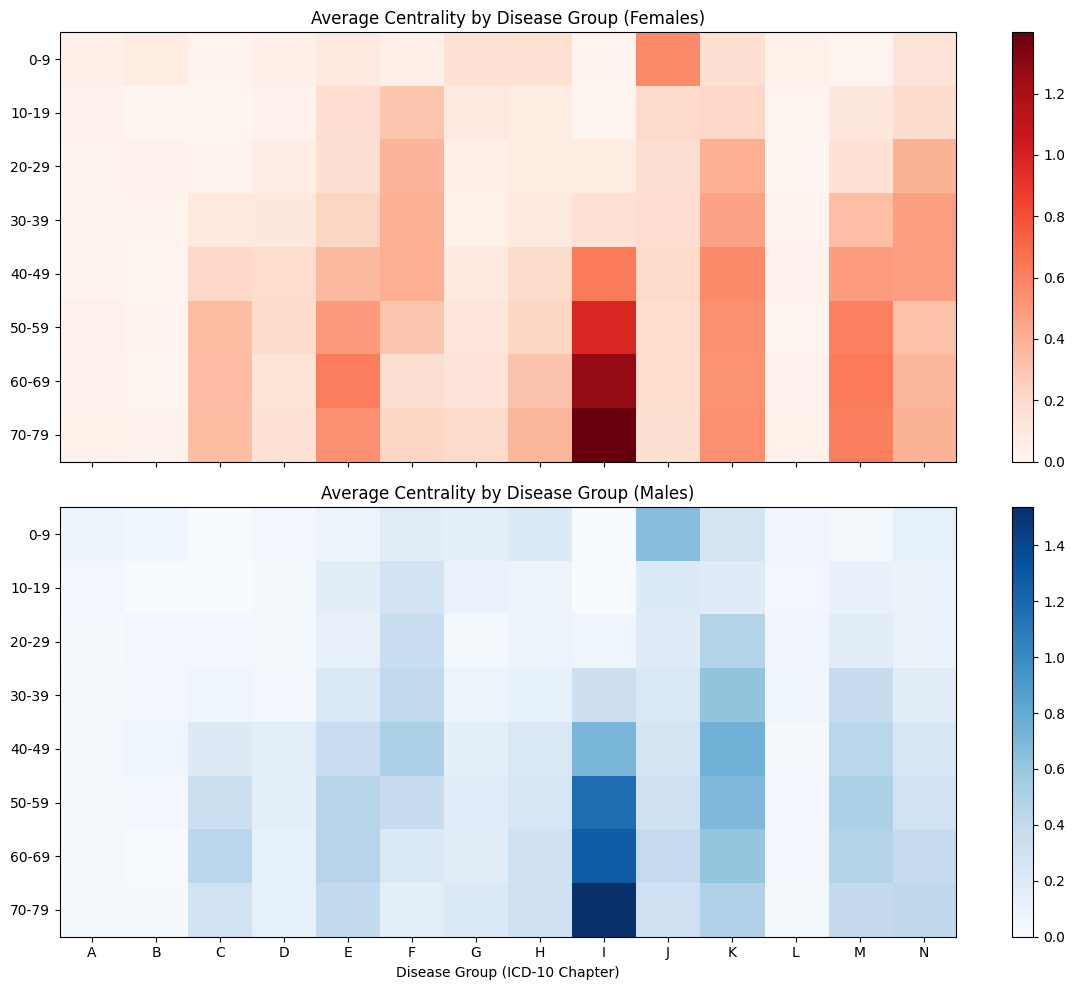

In [87]:
# Group diseases by their first letter and calculate the average centrality for each group.
from collections import defaultdict

groups = defaultdict(list)
for i, lab in enumerate(label_all_code):
    first = str(lab)[0].upper() if str(lab) else "#"
    groups[first].append(i)

# Sort groups alphabetically by letter
letters = sorted(groups.keys())

# Calculate average centrality for female population
avg_cen_f_by_group = []
for letter in letters:
    indices = groups[letter]
    group_avg = cen_f[indices, :].mean(axis=0)
    avg_cen_f_by_group.append(group_avg)

avg_cen_f_by_group = np.array(avg_cen_f_by_group)

# Calculate average centrality for male population
avg_cen_m_by_group = []
for letter in letters:
    indices = groups[letter]
    group_avg = cen_m[indices, :].mean(axis=0)
    avg_cen_m_by_group.append(group_avg)

avg_cen_m_by_group = np.array(avg_cen_m_by_group)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot for females
im1 = ax1.imshow(avg_cen_f_by_group.T, aspect='auto', cmap='Reds', interpolation='nearest')
ax1.set_yticks(range(len(age_groups)))
ax1.set_yticklabels(age_groups)
ax1.set_title('Average Centrality by Disease Group (Females)')
fig.colorbar(im1, ax=ax1, orientation='vertical')

# Plot for males
im2 = ax2.imshow(avg_cen_m_by_group.T, aspect='auto', cmap='Blues', interpolation='nearest')
ax2.set_xticks(range(len(letters)))
ax2.set_xticklabels(letters)
ax2.set_xlabel('Disease Group (ICD-10 Chapter)')
ax2.set_yticks(range(len(age_groups)))
ax2.set_yticklabels(age_groups)
ax2.set_title('Average Centrality by Disease Group (Males)')
fig.colorbar(im2, ax=ax2, orientation='vertical')

plt.tight_layout()
plt.show()


In [89]:
cen_f.shape

(1080, 8)

C:\Users\matte\AppData\Local\Temp\ipykernel_24020\3556008141.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


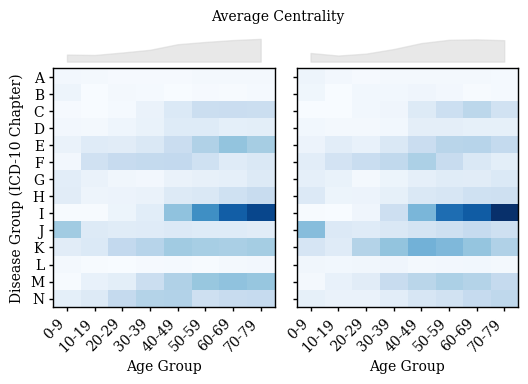

In [101]:
# --- CENTRALITY ANALYSIS ---

# Calculate average centrality for female population
avg_cen_f_by_group = []
for letter in letters:
    indices = groups[letter]
    # The shape of cen_f is (diseases, age_groups), so we select rows and average over them
    group_avg = cen_f[indices, :].mean(axis=0)
    avg_cen_f_by_group.append(group_avg)

avg_cen_f_by_group = np.array(avg_cen_f_by_group)

# Calculate average centrality for male population
avg_cen_m_by_group = []
for letter in letters:
    indices = groups[letter]
    group_avg = cen_m[indices, :].mean(axis=0)
    avg_cen_m_by_group.append(group_avg)

avg_cen_m_by_group = np.array(avg_cen_m_by_group)

# --- Plotting Centrality ---
plt.rcParams['font.family'] = 'serif'
fig = plt.figure(figsize=(6, 3.5))
gs = fig.add_gridspec(2, 2, height_ratios=[.5, 5], hspace=0.05, wspace=0.1)

(ax1_density, ax2_density), (ax1, ax2) = gs.subplots(sharex='col', sharey='row')

fig.suptitle('Average Centrality', fontsize=10, y=0.96)

# Determine shared color scale
vmin = min(avg_cen_f_by_group.min(), avg_cen_m_by_group.min())
vmax = max(avg_cen_f_by_group.max(), avg_cen_m_by_group.max())

# --- Density Plots (Top Row) ---
# Female density
density_f = avg_cen_f_by_group.mean(axis=0)
ax1_density.fill_between(range(len(age_groups)), density_f, color='lightgrey', alpha=0.5)
ax1_density.spines['top'].set_visible(False)
ax1_density.spines['right'].set_visible(False)
ax1_density.spines['left'].set_visible(False)
ax1_density.set_yticks([])
ax1_density.set_ylim(bottom=0)
ax1_density.axis('off') # Turn off axis

# Male density
density_m = avg_cen_m_by_group.mean(axis=0)
ax2_density.fill_between(range(len(age_groups)), density_m, color='lightgrey', alpha=0.5)
ax2_density.spines['top'].set_visible(False)
ax2_density.spines['right'].set_visible(False)
ax2_density.spines['left'].set_visible(False)
ax2_density.set_yticks([])
ax2_density.set_ylim(bottom=0)
ax2_density.axis('off') # Turn off axis


# --- Heatmaps (Bottom Row) ---
# Plot for females (left)
im = ax1.imshow(avg_cen_f_by_group, aspect='auto', cmap='Blues', interpolation='nearest', vmin=vmin, vmax=vmax)
ax1.set_xticks(range(len(age_groups)))
ax1.set_xticklabels(age_groups, rotation=45, ha="right")
ax1.set_xlabel('Age Group')
ax1.set_yticks(range(len(letters)))
ax1.set_yticklabels(letters)
ax1.set_ylabel('Disease Group (ICD-10 Chapter)')
for spine in ax1.spines.values():
    spine.set_linewidth(1)
ax1.tick_params(width=1)
ax1.tick_params(length=3)

# Plot for males (right)
ax2.imshow(avg_cen_m_by_group, aspect='auto', cmap='Blues', interpolation='nearest', vmin=vmin, vmax=vmax)
ax2.set_xticks(range(len(age_groups)))
ax2.set_xticklabels(age_groups, rotation=45, ha="right")
ax2.set_xlabel('Age Group')
for spine in ax2.spines.values():
    spine.set_linewidth(1)
ax2.tick_params(width=1)
ax2.tick_params(length=3)

# # Add a single colorbar for both heatmaps
# cbar = fig.colorbar(im, ax=[ax1, ax2], orientation='vertical', fraction=0.05, pad=0.05)
# cbar.set_label('Centrality')


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('../Figures/figure_centrality.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

C:\Users\matte\AppData\Local\Temp\ipykernel_24020\2982968984.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


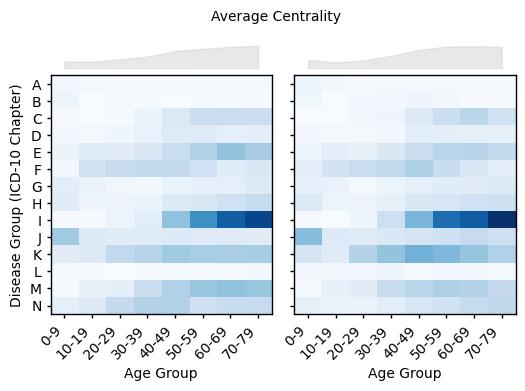

(<Figure size 700x600 with 2 Axes>,
 <Axes: title={'center': 'COMORBIDITY NETWORK (Female centrality)'}>)

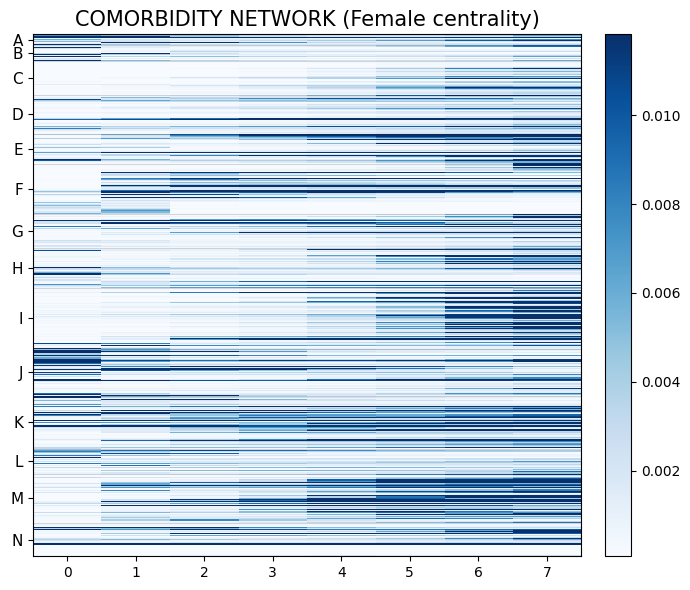

: 

In [ ]:
imshow_grouped_by_initial(prev_f[:, indx_nonzero_cen_f].T, labels_list = labels_nonzero_cen_f, cmap="Blues", title="COMORBIDITY NETWORK (Female centrality)")

In [31]:
imshow_grouped_by_initial(mort_f[:, indx_nonzero_cen_f].T, labels_list = labels_nonzero_cen_f, cmap="Blues", title="COMORBIDITY NETWORK (Female centrality)")

InvalidIndexError: (slice(None, None, None), [2, 4, 8, 9, 11, 35, 39, 41, 53, 59, 87, 89, 95, 96, 98, 99, 100, 106, 109, 112, 113, 115, 167, 169, 170, 172, 174, 175, 182, 183, 186, 188, 189, 191, 192, 193, 194, 195, 198, 202, 204, 210, 211, 227, 228, 230, 233, 234, 237, 239, 243, 244, 245, 246, 248, 249, 251, 254, 273, 274, 277, 278, 279, 283, 284, 290, 292, 293, 295, 296, 297, 298, 299, 301, 302, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 320, 321, 322, 323, 327, 328, 329, 331, 334, 342, 345, 347, 348, 349, 350, 352, 353, 354, 355, 356, 358, 360, 362, 372, 380, 384, 386, 391, 395, 400, 401, 406, 407, 409, 410, 412, 413, 414, 415, 417, 418, 419, 420, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 434, 436, 437, 439, 440, 442, 446, 447, 448, 449, 452, 453, 455, 457, 458, 459, 460, 463, 466, 467, 469, 475, 480, 481, 482, 483, 484, 485, 487, 488, 489, 490, 491, 494, 511, 512, 516, 518, 519, 521, 524, 525, 526, 527, 528, 529, 530, 531, 532, 534, 535, 536, 537, 538, 539, 542, 543, 544, 546, 550, 551, 552, 553, 554, 555, 557, 559, 566, 571, 572, 576, 577, 580, 582, 583, 584, 589, 590, 591, 592, 593, 595, 598, 600, 601, 603, 604, 605, 610, 611, 613, 614, 616, 617, 618, 619, 621, 622, 625, 627, 628, 629, 630, 631, 637, 638, 639, 640, 642, 643, 644, 645, 646, 647, 648, 649, 651, 652, 653, 654, 656, 657, 660, 661, 662, 668, 670, 671, 672, 673, 674, 675, 676, 677, 679, 680, 681, 682, 683, 684, 685, 686, 688, 689, 690, 691, 692, 693, 694, 696, 697, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 710, 711, 712, 713, 714, 715, 716, 717, 719, 720, 721, 724, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 758, 761, 762, 763, 765, 766, 767, 769, 770, 771, 772, 773, 776, 777, 779, 780, 782, 783, 784, 785, 787, 790, 791, 792, 794, 795, 798, 800, 801, 803, 805, 807, 808, 809, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 825, 826, 828, 829, 830, 831, 832, 833, 834, 836, 837, 838, 839, 840, 841, 844, 845, 848, 849, 850, 851, 852, 853, 859, 860, 861, 862, 866, 868, 869, 870, 876, 883, 886, 895, 896, 905, 909, 910, 916, 917, 924, 928, 929, 931, 933, 934, 935, 937, 938, 939, 940, 941, 942, 943, 945, 949, 952, 953, 954, 955, 956, 957, 958, 960, 961, 962, 963, 966, 968, 969, 970, 972, 973, 974, 976, 977, 978, 979, 980, 981, 986, 987, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1006, 1007, 1009, 1010, 1014, 1015, 1016, 1017, 1018, 1020, 1021, 1022, 1024, 1026, 1027, 1028, 1031, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1045, 1079])

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from itertools import combinations
import scipy.stats

# Store cluster labels and cen_fters for each age group and sex
cluster_labels_f = []
cluster_cen_fters_f = []
cluster_labels_m = []
cluster_cen_fters_m = []

feature_names = ['cen_f', 'degree', 'betweenness', 'mort_inf', 'mort_inf_degree', 'prev', 'mort']

for i in range(8):
    features_f = np.stack([
        cen_f[:, i],
        #cen_f_degree_f[:, i],
        cen_f_betweeness_f[:, i],
        #mort_inf_f[:, i],
        #mort_inf_degree_f[:, i],
        #prev_f.T[:, i],
        #mort_F.T[:, i]
    ], axis=1)
    features_m = np.stack([
        cen_m[:, i],
        #cen_f_degree_m[:, i],
        cen_f_betweeness_m[:, i],
        #mort_inf_m[:, i],
        #mort_inf_degree_m[:, i],
        #prev_m.T[:, i],
        #mort_M.T[:, i]
    ], axis=1)
    
    import matplotlib.pyplot as plt

    features_f = scipy.stats.zscore(features_f, axis=0)
    features_m = scipy.stats.zscore(features_m, axis=0)



    # Compute all pairwise products between different features (off-diagonal)

    n_features = features_f.shape[1]
    pair_indices = list(combinations(range(n_features), 2))  # 21 pairs

    # For each row, compute all pairwise products
    features_f_pairwise = np.empty((features_f.shape[0], len(pair_indices)*2))
    for idx, (i, j) in enumerate(pair_indices):
        features_f_pairwise[:, idx] = features_f[:, i] * features_f[:, j] * np.sign(np.sign(features_f[:, i]) + np.sign(features_f[:, j]))  # product of features, with sign
        features_f_pairwise[:, idx + len(pair_indices)] = features_f[:, j] * features_f[:, i] *  np.sign(np.sign(features_f[:, j]) + np.sign(features_f[:, i]))  # product of features, with sign

    # If you want only unique products (i<j), use only the first 21 columns:
    features_f_pairwise = features_f_pairwise[:, :len(pair_indices)]

    order = np.argsort(features_f_pairwise[:,-1])

    plt.imshow(features_f_pairwise[order,:], aspect='auto', interpolation='none', vmin = np.percen_ftile(features_f_pairwise, 10), vmax = np.percen_ftile(features_f_pairwise, 99))

    plt.xticks(np.arange(3), pair_indices, rotation = 45)
    plt.colorbar()
    plt.show()
    plt.close()

    mask = np.where(features_f_pairwise.mean(1) > 0, True, False)

    label = ['high betweeness and high prev', 'high mort and high betweeness', 'high mort and high prev']
    for j in range(3):
        vals = features_f_pairwise[:, j]
        pos_idx = np.where(vals > 0)[0]
        colors = [letter_to_hex[label_all_code[n][0]] for n in pos_idx]

        plt.figure(figsize=(12, 3))
        plt.bar(pos_idx, vals[pos_idx], color=colors)
        plt.title(label[j])
        # Show only the top 5 bars if there are at least 5
        top_n = min(5, len(pos_idx))
        if top_n > 0:
            top_indices = np.argsort(vals[pos_idx])[-top_n:]  # indices of top 5 values
            top_pos_idx = pos_idx[top_indices]
            top_vals = vals[top_pos_idx]
            top_colors = [colors[i] for i in top_indices]
            plt.bar(top_pos_idx, top_vals, color=top_colors)
            plt.xticks(top_pos_idx, [f"{label_all_code[j]}" for j in top_pos_idx], rotation=45)

        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.show()

    # features_f_pairwise now has shape (1080, 21)

    # If you want all ordered pairs (i != j), use:
    # features_f_pairwise_full = np.empty((features_f.shape[0], n_features*(n_features-1)))
    # idx = 0
    # for i in range(n_features):
    #     for j in range(n_features):
    #         if i != j:
    #             features_f_pairwise_full[:, idx] = features_f[:, i] * features_f[:, j]
    #             idx += 1
    # features_f_pairwise_full.shape  # (1080, 42)

    


NameError: name 'cen_f_betweeness_f' is not defined

C:\Users\matte\AppData\Local\Temp\ipykernel_24020\3989451053.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


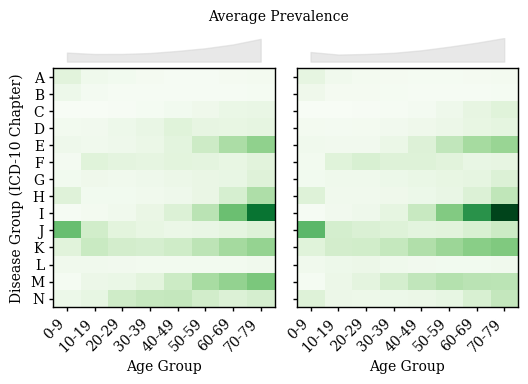

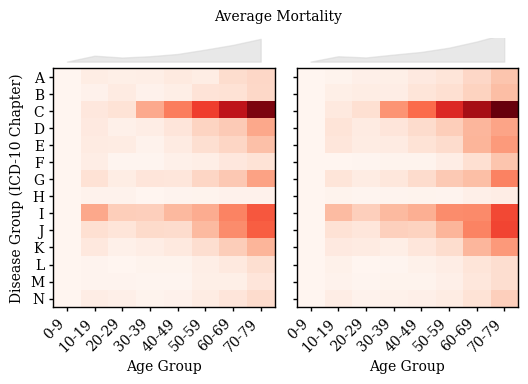

In [103]:
# --- PREVALENCE ANALYSIS ---

# Calculate average prevalence for female population
avg_prev_f_by_group = []
for letter in letters:
    indices = groups[letter]
    # The shape of prev_f is (age_groups, diseases), so we need to select columns
    group_avg = prev_f[:, indices].mean(axis=1)
    avg_prev_f_by_group.append(group_avg)

avg_prev_f_by_group = np.array(avg_prev_f_by_group)

# Calculate average prevalence for male population
avg_prev_m_by_group = []
for letter in letters:
    indices = groups[letter]
    group_avg = prev_m[:, indices].mean(axis=1)
    avg_prev_m_by_group.append(group_avg)

avg_prev_m_by_group = np.array(avg_prev_m_by_group)

# --- Plotting Prevalence ---
fig = plt.figure(figsize=(6, 3.5))
gs = fig.add_gridspec(2, 2, height_ratios=[.5, 5], hspace=0.05, wspace=0.1)

(ax1_density, ax2_density), (ax1, ax2) = gs.subplots(sharex='col', sharey='row')

fig.suptitle('Average Prevalence', fontsize=10, y=.96)

# Determine shared color scale
vmin = min(avg_prev_f_by_group.min(), avg_prev_m_by_group.min())
vmax = max(avg_prev_f_by_group.max(), avg_prev_m_by_group.max())

# --- Density Plots (Top Row) ---
# Female density
density_f = avg_prev_f_by_group.mean(axis=0)
ax1_density.fill_between(range(len(age_groups)), density_f, color='lightgrey', alpha=0.5)
ax1_density.spines['top'].set_visible(False)
ax1_density.spines['right'].set_visible(False)
ax1_density.spines['left'].set_visible(False)
ax1_density.set_yticks([])
ax1_density.set_ylim(bottom=0)
ax1_density.axis('off') # Turn off axis

# Male density
density_m = avg_prev_m_by_group.mean(axis=0)
ax2_density.fill_between(range(len(age_groups)), density_m, color='lightgrey', alpha=0.5)
ax2_density.spines['top'].set_visible(False)
ax2_density.spines['right'].set_visible(False)
ax2_density.spines['left'].set_visible(False)
ax2_density.set_yticks([])
ax2_density.set_ylim(bottom=0)
ax2_density.axis('off') # Turn off axis


# --- Heatmaps (Bottom Row) ---
# Plot for females (left)
im = ax1.imshow(avg_prev_f_by_group, aspect='auto', cmap='Greens', interpolation='nearest', vmin=vmin, vmax=vmax)
ax1.set_xticks(range(len(age_groups)))
ax1.set_xticklabels(age_groups, rotation=45, ha="right")
ax1.set_xlabel('Age Group')
ax1.set_yticks(range(len(letters)))
ax1.set_yticklabels(letters)
ax1.set_ylabel('Disease Group (ICD-10 Chapter)')
# ax1.set_title('Females', fontsize=10)
for spine in ax1.spines.values():
    spine.set_linewidth(1)
ax1.tick_params(width=1)
ax1.tick_params(length=3) # make ticks a bit shorter



# Plot for males (right)
ax2.imshow(avg_prev_m_by_group, aspect='auto', cmap='Greens', interpolation='nearest', vmin=vmin, vmax=vmax)
ax2.set_xticks(range(len(age_groups)))
ax2.set_xticklabels(age_groups, rotation=45, ha="right")
ax2.set_xlabel('Age Group')
# ax2.set_title('Males', fontsize=10)
for spine in ax2.spines.values():
    spine.set_linewidth(1)
ax2.tick_params(width=1)
ax2.tick_params(length=3) # make ticks a bit shorter

# font style sans serif
plt.rcParams['font.family'] = 'serif'

# Add a single colorbar for the row
# fig.colorbar(im, ax=[ax1, ax2], orientation='vertical', label='Average Prevalence')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('../Figures/figure_prevalence.png', dpi=600, bbox_inches='tight', transparent=True)

plt.show()


# --- MORTALITY ANALYSIS ---

# Calculate average mortality for female population
avg_mort_f_by_group = []
for letter in letters:
    indices = groups[letter]
    group_avg = mort_F[:, indices].mean(axis=1)
    avg_mort_f_by_group.append(group_avg)
avg_mort_f_by_group = np.array(avg_mort_f_by_group)

# Calculate average mortality for male population
avg_mort_m_by_group = []
for letter in letters:
    indices = groups[letter]
    group_avg = mort_M[:, indices].mean(axis=1)
    avg_mort_m_by_group.append(group_avg)
avg_mort_m_by_group = np.array(avg_mort_m_by_group)

# --- Plotting Mortality ---
fig = plt.figure(figsize=(6, 3.5))
gs = fig.add_gridspec(2, 2, height_ratios=[0.5, 5], hspace=0.05, wspace=0.1)

(ax1_density, ax2_density), (ax1, ax2) = gs.subplots(sharex='col', sharey='row')

fig.suptitle('Average Mortality', fontsize=10, y =0.96)
# font style sans serif
plt.rcParams['font.family'] = 'serif'
# Determine shared color scale
vmin = min(avg_mort_f_by_group.min(), avg_mort_m_by_group.min())
vmax = max(avg_mort_f_by_group.max(), avg_mort_m_by_group.max())

# --- Density Plots (Top Row) ---
# Female density
density_f = avg_mort_f_by_group.mean(axis=0)
ax1_density.fill_between(range(len(age_groups)), density_f, color='lightgrey', alpha=0.5)
ax1_density.spines['top'].set_visible(False)
ax1_density.spines['right'].set_visible(False)
ax1_density.spines['left'].set_visible(False)
ax1_density.set_yticks([])
ax1_density.set_ylim(bottom=0)
ax1_density.axis('off') # Turn off axis

# Male density
density_m = avg_mort_m_by_group.mean(axis=0)
ax2_density.fill_between(range(len(age_groups)), density_m, color='lightgrey', alpha=0.5)
ax2_density.spines['top'].set_visible(False)
ax2_density.spines['right'].set_visible(False)
ax2_density.spines['left'].set_visible(False)
ax2_density.set_yticks([])
ax2_density.set_ylim(bottom=0)
ax2_density.axis('off') # Turn off axis

# --- Heatmaps (Bottom Row) ---
# Plot for females (left)
im = ax1.imshow(avg_mort_f_by_group, aspect='auto', cmap='Reds', interpolation='nearest', vmin=vmin, vmax=vmax)
ax1.set_xticks(range(len(age_groups)))
ax1.set_xticklabels(age_groups, rotation=45, ha="right")
ax1.set_xlabel('Age Group')
ax1.set_yticks(range(len(letters)))
ax1.set_yticklabels(letters)
ax1.set_ylabel('Disease Group (ICD-10 Chapter)')
# ax1.set_title('Females', fontsize=10)
for spine in ax1.spines.values():
    spine.set_linewidth(1)
ax1.tick_params(width=1)
ax1.tick_params(length=3) # make ticks a bit shorter


# Plot for males (right)
ax2.imshow(avg_mort_m_by_group, aspect='auto', cmap='Reds', interpolation='nearest', vmin=vmin, vmax=vmax)
ax2.set_xticks(range(len(age_groups)))
ax2.set_xticklabels(age_groups, rotation=45, ha="right")
ax2.set_xlabel('Age Group')
# ax2.set_title('Males', fontsize=10)
ax2_density.set_ylim(bottom=0)
ax2_density.set_yticklabels([])
ax2_density.tick_params(axis='y', length=0)
for spine in ax2.spines.values():
    spine.set_linewidth(1)
ax2.tick_params(length=3) # make ticks a bit shorter
ax2.tick_params(width=1)

# Add a single colorbar for the row
#fig.colorbar(im, ax=[ax1, ax2], orientation='vertical', label='Average Mortality')
plt.savefig('../Figures/figure_mortality.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

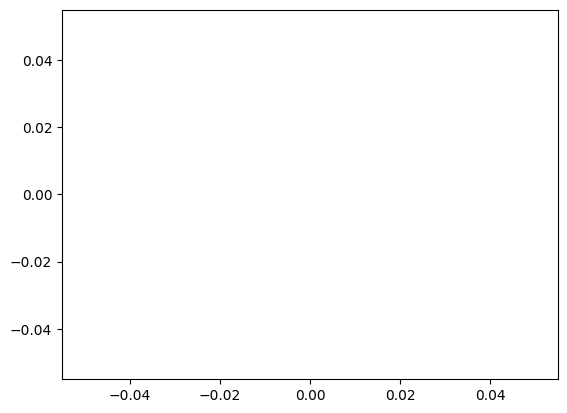

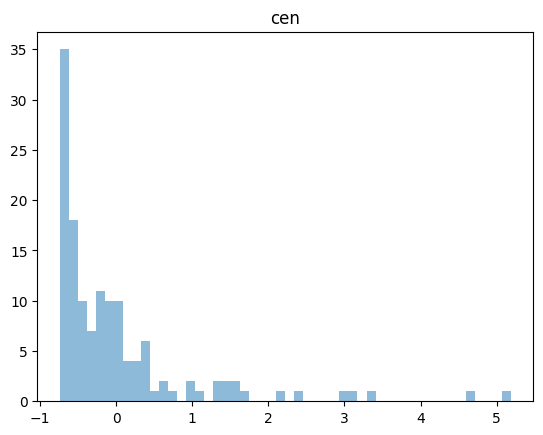

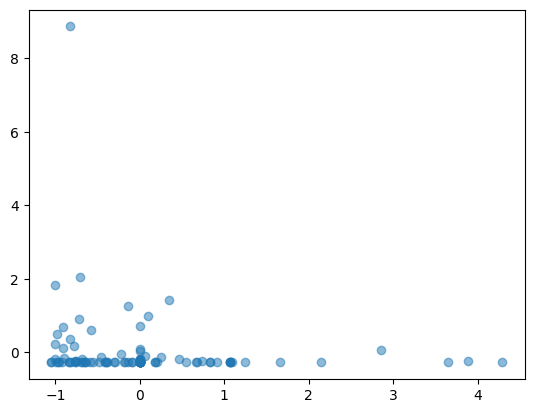

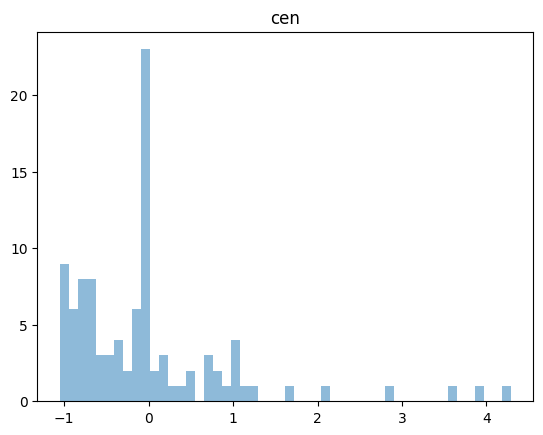

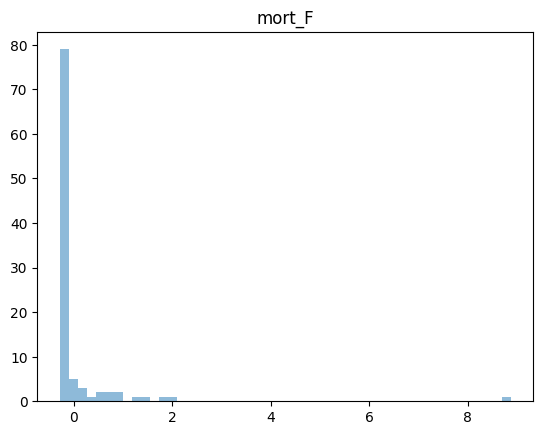

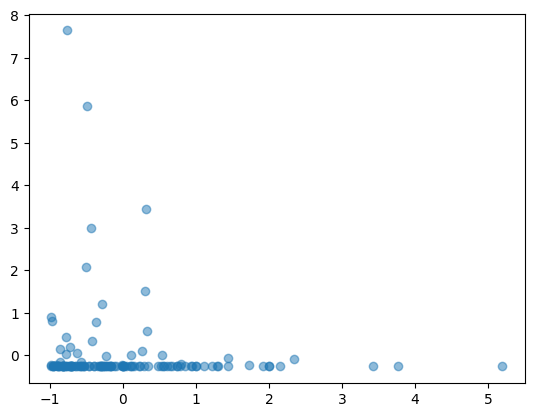

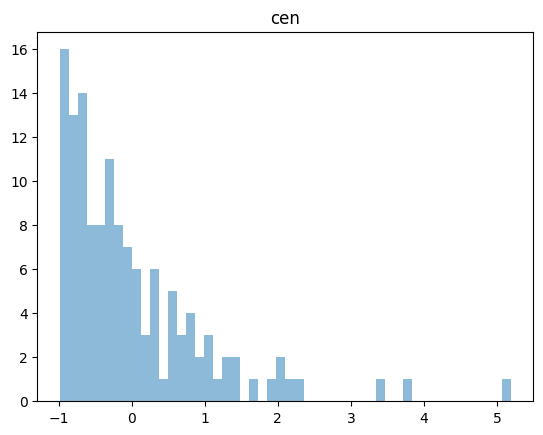

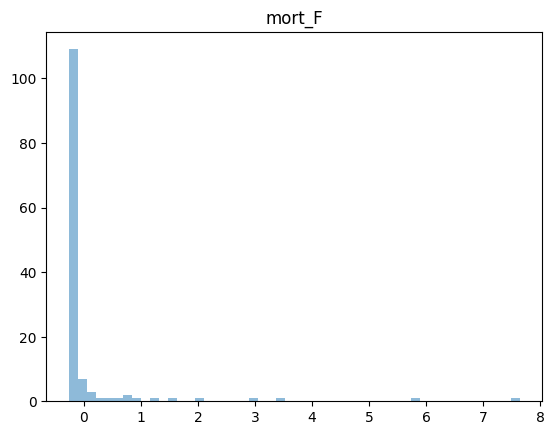

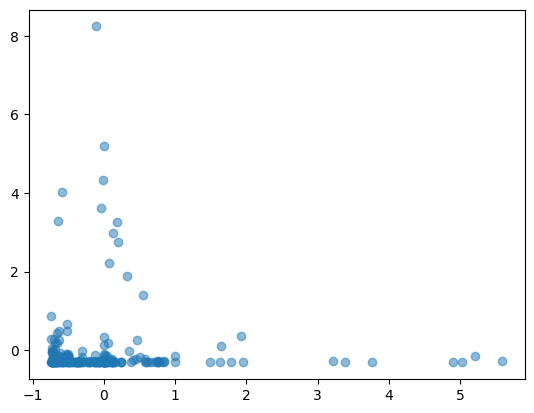

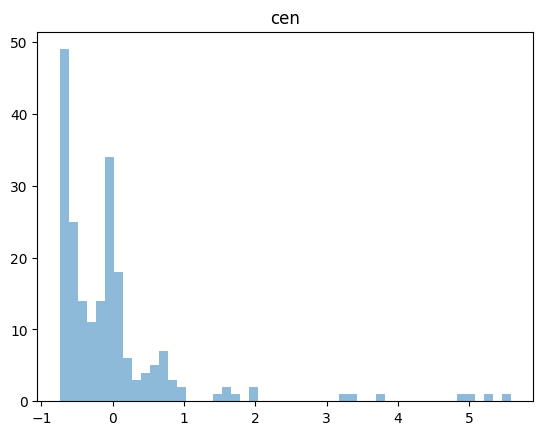

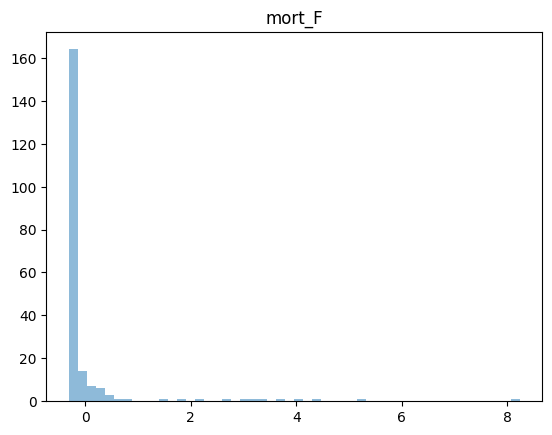

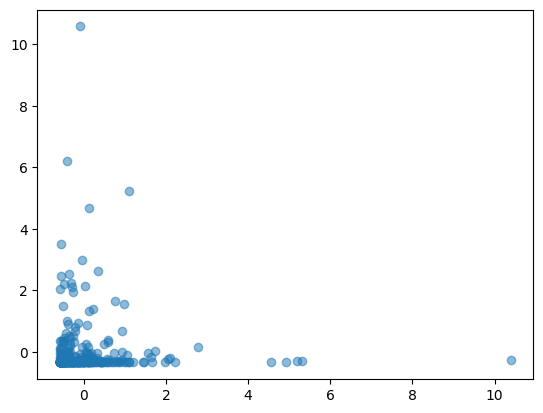

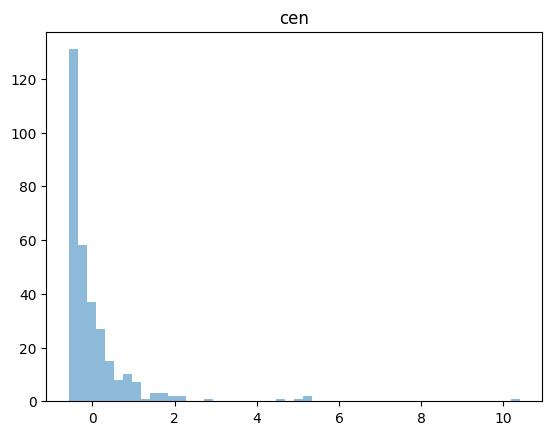

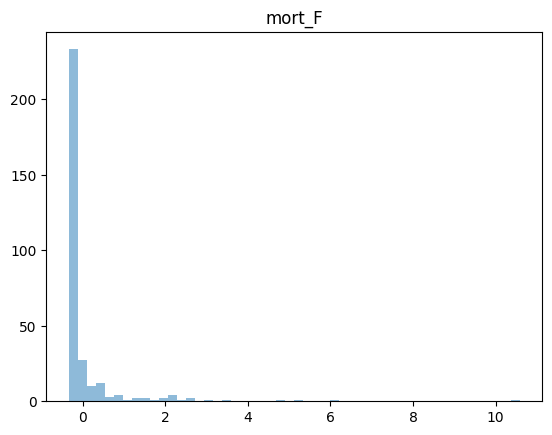

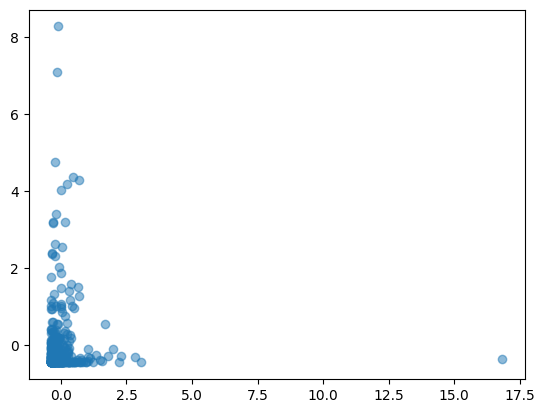

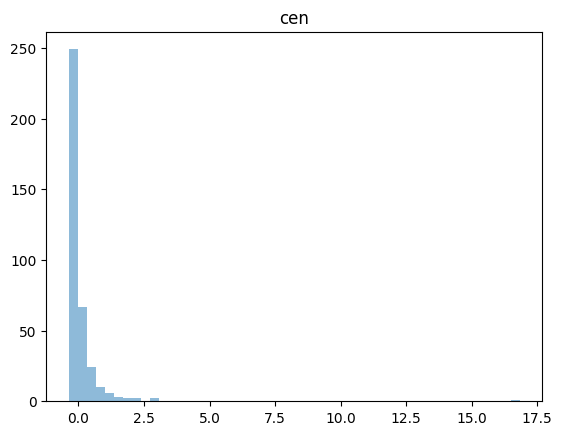

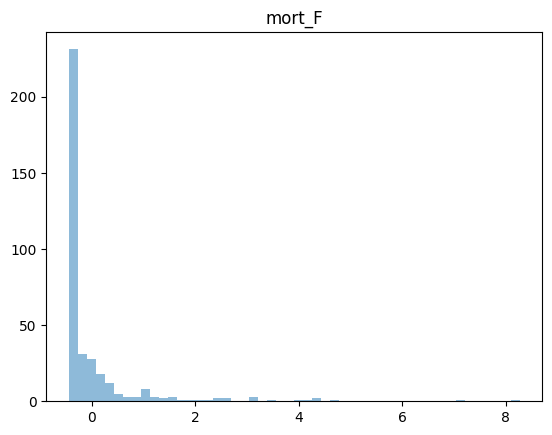

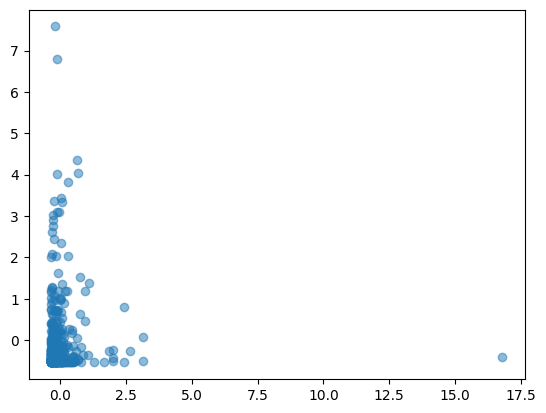

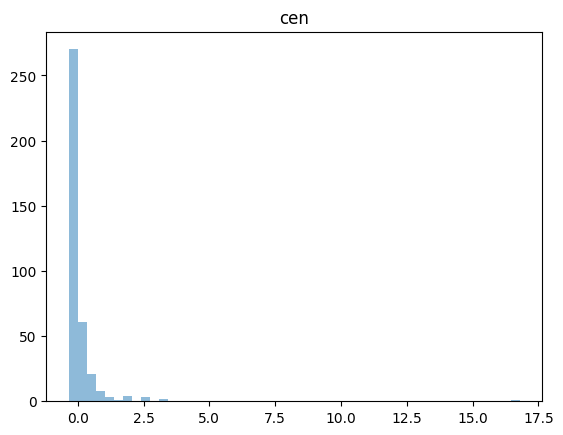

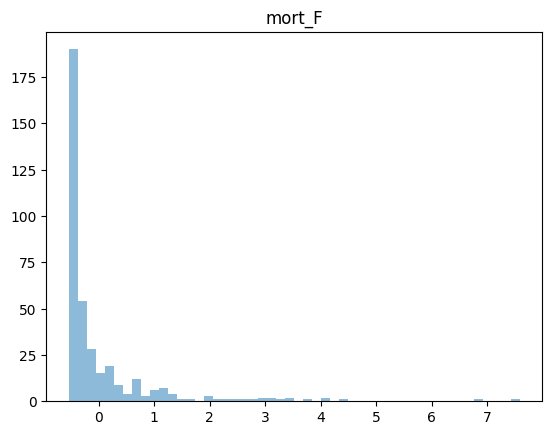

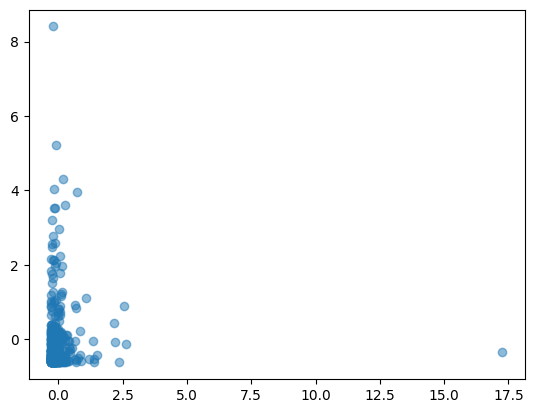

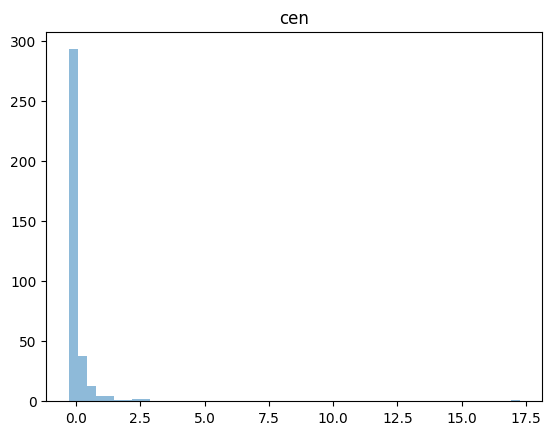

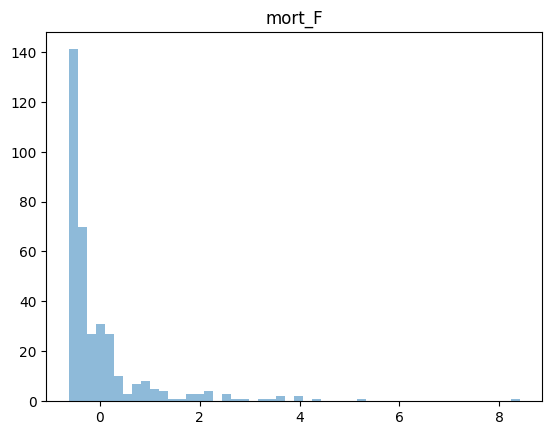

In [ ]:
mask_zeros_cen_f = np.where(cen_f.sum(1) > 0)[0]
mask_zeros_mort_F = np.where(mort_F.sum(0) != 0)[0]

import scipy
for i in range(8):
    mask_zeros_cen_f = np.where(cen_f[:,i] > 0)[0]
    plt.scatter(scipy.stats.zscore(cen_f[mask_zeros_cen_f, i]), scipy.stats.zscore(mort_F[i, mask_zeros_cen_f]), alpha=0.5)

    plt.show()
    plt.close()

    plt.hist(scipy.stats.zscore(cen_f[mask_zeros_cen_f, i]), bins=50, alpha=0.5, label='cen_f')
    plt.title('cen')
    plt.show()
    plt.close()

    if i !=0:
        plt.hist(scipy.stats.zscore(mort_F[i, mask_zeros_cen_f]), bins=50, alpha=0.5, label='mort_F')
        plt.title('mort_F')
        plt.show()
        plt.close()

In [ ]:
data = cen

In [24]:
# Select only rows in cen_f where the sum across columns is not zero
nonzero_cen_mask = cen_f.sum(axis=1) != 0
cen_nonzero = cen_f[nonzero_cen_mask, :]

# ICA on nonzero rows only
n_components_ica = 3  # You can change this as needed
ica_cen = FastICA(n_components=n_components_ica, random_state=0, max_iter=1000)
S_ica_cen = ica_cen.fit_transform(cen_nonzero)
order_ica_cen = np.argsort(S_ica_cen[:, 0])
cen_ica_ordered = cen_nonzero[order_ica_cen, :]

# Plot the reordered cen_f matrix
plt.figure(figsize=(5,3))
vmin_cen = np.percentile(cen_nonzero, 10)
vmax_cen = np.percentile(cen_nonzero, 90)
plt.imshow(cen_ica_ordered, cmap='viridis', aspect='auto', interpolation=None, vmin=vmin_cen, vmax=vmax_cen)
#plt.title('strength cen_ftrality over time')
plt.xticks(range(8), ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79'], rotation=45)
plt.xlabel('Age Group')
plt.yticks([])
plt.ylabel('Diseases')


cbar = plt.colorbar()
cbar.set_label('strength', fontsize=12)
plt.show()
plt.savefig('./../Figures/cen_f_ica_ordered_overtime.png', dpi=600, bbox_inches='tight')

# Compute and plot the correlation matrix of the reordered cen_f
corr_cen_ica = np.corrcoef(cen_ica_ordered)
plt.figure(figsize=(5,3))
plt.imshow(corr_cen_ica, cmap='coolwarm', aspect='auto')
plt.xticks([])
plt.yticks([])
plt.xlabel('Diseases')
plt.ylabel('Diseases')
#plt.title('Correlation Matrix of ICA-Ordered cen_f (nonzero rows)')
cbar = plt.colorbar()
cbar.set_label('corr', fontsize=12)
plt.show()
plt.savefig('./../Figures/corr_cen_f_ica_ordered.png', dpi=600, bbox_inches='tight')

NameError: name 'FastICA' is not defined

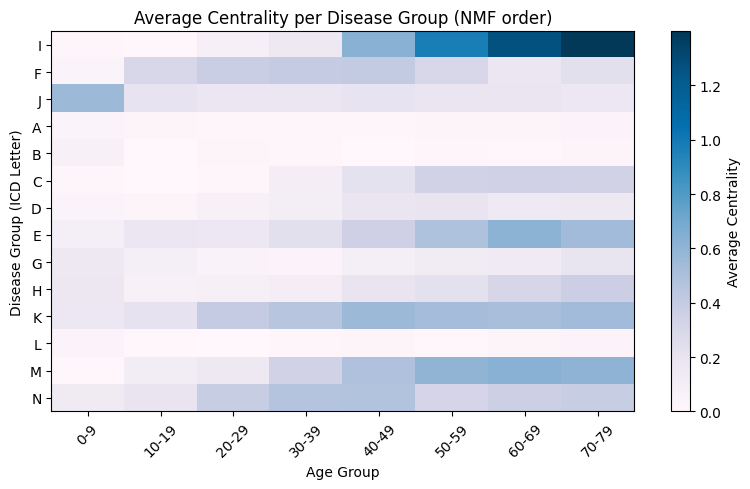

In [27]:
from sklearn.decomposition import NMF

# Compute average centrality per disease group (first letter) for each age group
group_letters = sorted(set([code[0] for code in label_all_code]))
avg_centrality = np.zeros((len(group_letters), cen_f.shape[1]))  # (14, 8)

for i, letter in enumerate(group_letters):
    indices = [idx for idx, code in enumerate(label_all_code) if code[0] == letter]
    if indices:
        avg_centrality[i, :] = cen_f[indices, :].mean(axis=0)

# NMF decomposition (3 components)
n_components = 3
nmf = NMF(n_components=n_components, init='random', random_state=0, max_iter=1000)
W = nmf.fit_transform(np.abs(avg_centrality))
H = nmf.components_

# For each component, find the group with the highest loading
top_groups = np.argmax(W, axis=0)
# Get unique order by component (if duplicates, keep order of appearance)
ordered_indices = []
for idx in top_groups:
    if idx not in ordered_indices:
        ordered_indices.append(idx)
# Add remaining groups not in top_groups
for idx in range(len(group_letters)):
    if idx not in ordered_indices:
        ordered_indices.append(idx)

# Plot in the new order
plt.figure(figsize=(8, 5))
im = plt.imshow(avg_centrality[ordered_indices, :], aspect='auto', cmap='PuBu')
plt.colorbar(im, label='Average Centrality')
plt.xticks(ticks=np.arange(len(age_groups)), labels=age_groups, rotation=45)
plt.yticks(ticks=np.arange(len(group_letters)), labels=[group_letters[i] for i in ordered_indices])
plt.xlabel('Age Group')
plt.ylabel('Disease Group (ICD Letter)')
plt.title('Average Centrality per Disease Group (NMF order)')
plt.tight_layout()
plt.show()

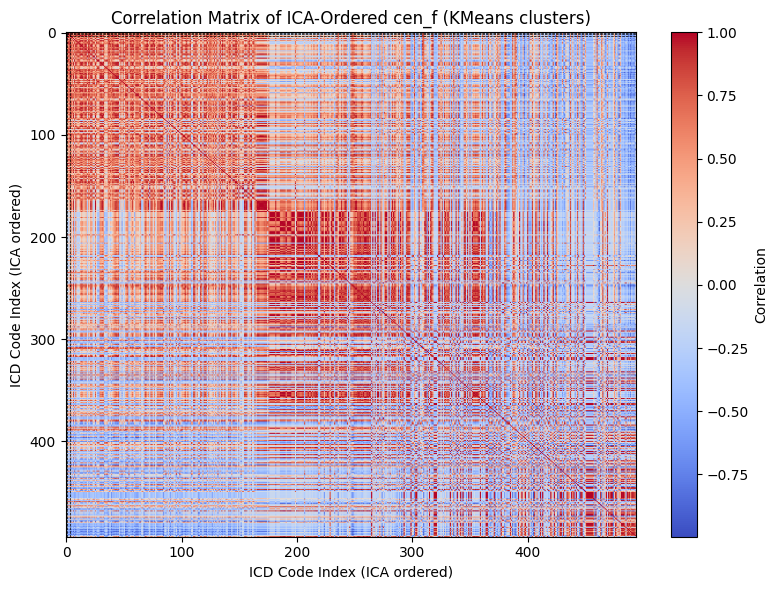

Cluster 0: 284 elements
Cluster 1: 88 elements
Cluster 2: 122 elements


In [28]:
from sklearn.cluster import KMeans

# Choose the number of clusters (e.g., 4, but you can adjust)
n_clusters = 3
corr_cen_f_nonzero = np.corrcoef(cen_nonzero)

# Perform k-means clustering on the correlation matrix of ICA-ordered cen_f
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
labels_kmeans = kmeans.fit_predict(corr_cen_f_nonzero)

# Plot the reordered correlation matrix with cluster labels
plt.figure(figsize=(8, 6))
plt.imshow(corr_cen_ica, cmap='coolwarm', aspect='auto')
plt.title('Correlation Matrix of ICA-Ordered cen_f (KMeans clusters)')
plt.colorbar(label='Correlation')
plt.xlabel('ICD Code Index (ICA ordered)')
plt.ylabel('ICD Code Index (ICA ordered)')

# Optionally, show cluster boundaries
for c in range(n_clusters):
    idx = np.where(labels_kmeans == c)[0]
    if len(idx) > 0:
        plt.axhline(idx[0], color='k', linestyle='--', linewidth=0.5)
        plt.axvline(idx[0], color='k', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Show cluster sizes
for c in range(n_clusters):
    print(f"Cluster {c}: {np.sum(labels_kmeans == c)} elements")

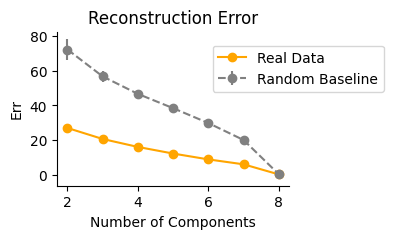

In [31]:
from sklearn.decomposition import NMF

component_range = range(2, 9)
reconstruction_errors = []
random_errors_mean = []
random_errors_std = []

n_random = 200 # Number of random permutations

relative_distances = []

for n in component_range:
    # Fit NMF to real data
    nmf_model = NMF(n_components=n, init='random', random_state=0, max_iter=1000)
    W_tmp = nmf_model.fit_transform(np.abs(cen_nonzero))
    error = nmf_model.reconstruction_err_
    reconstruction_errors.append(error)
    
    # Fit NMF to randomly permuted data
    rand_errs = []
    for _ in range(n_random):
        cen_shuffled = np.abs(cen_nonzero).copy().flatten()
        np.random.shuffle(cen_shuffled)
        cen_shuffled = cen_shuffled.reshape(cen_nonzero.shape)
        nmf_rand = NMF(n_components=n, init='random', random_state=None, max_iter=1000)
        nmf_rand.fit(cen_shuffled)
        rand_errs.append(nmf_rand.reconstruction_err_)
    random_errors_mean.append(np.mean(rand_errs))
    random_errors_std.append(np.std(rand_errs))

    relative_distance = (np.mean(rand_errs) - error) / np.std(rand_errs)
    relative_distances.append(relative_distance)

plt.figure(figsize=(3, 2))
plt.plot(component_range, reconstruction_errors, marker='o', label='Real Data', color='orange')
plt.errorbar(component_range, random_errors_mean, yerr=random_errors_std, fmt='--o', label='Random Baseline', color='gray')
plt.xlabel('Number of Components')
plt.ylabel('Err')
plt.title('Reconstruction Error')
plt.legend(loc='center left', bbox_to_anchor=(0.64, 0.76))
plt.grid(False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('./../Figures/nmf_reconstruction_error.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()


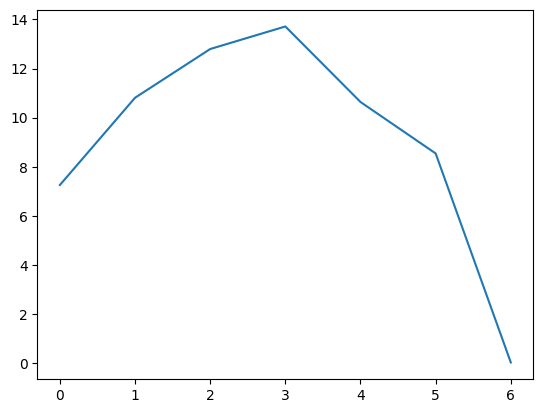

In [32]:
plt.plot(relative_distances)

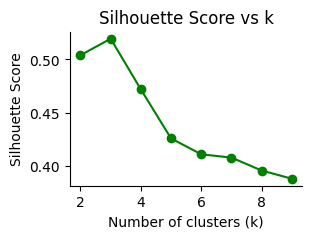

Best k (clusters) according to silhouette score and literature: 2


In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Try different values of k (number of clusters)
k_range = range(2, 10)
inertia = []
silhouette = []

corr_cen_nonzero = np.corrcoef(cen_nonzero)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = kmeans.fit_predict(corr_cen_nonzero)
    inertia.append(kmeans.inertia_)
    # Compute silhouette score only if k > 1 and less than number of samples
    if 1 < k < corr_cen_ica.shape[0]:
        sil = silhouette_score(corr_cen_nonzero, labels)
    else:
        sil = np.nan
    silhouette.append(sil)

"""BaseExceptionplt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('KMeans Inertia vs k')
plt.grid(True)"""

plt.figure(figsize=(3,2))
plt.plot(k_range, silhouette, marker='o', color='green')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.grid(False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('./../Figures/silhouette_score_vs_k.png', dpi=600, bbox_inches='tight')
plt.show()

# According to literature, 3-6 clusters are often used for disease network modules.
# Choose the k with the highest silhouette score in this range
best_k = k_range[np.nanargmax(silhouette[1:6])]   # 3-6 clusters
print(f"Best k (clusters) according to silhouette score and literature: {best_k}")

# Fit KMeans with the best k
kmeans_best = KMeans(n_clusters=best_k, random_state=0, n_init=10)
labels_best = kmeans_best.fit_predict(corr_cen_nonzero)



In [70]:
import numpy as np
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from joblib import Parallel, delayed
from scipy.spatial.distance import pdist, squareform

# ---------- Helpers ----------
def hoyer_sparsity(A):
    # Hoyer (2004) sparsity in [0,1]; higher = sparser
    A = np.asarray(A, dtype=float)
    n = A.size
    l1 = np.linalg.norm(A.ravel(), 1)
    l2 = np.linalg.norm(A.ravel(), 2)
    if l2 == 0:
        return 0.0
    return (np.sqrt(n) - (l1 / l2)) / (np.sqrt(n) - 1.0)

def explained_variance_r2(X, Xhat):
    num = np.sum((X - Xhat) ** 2)
    den = np.sum(X ** 2) + 1e-12
    return 1.0 - num / den

def nmf_once(X, r, init='nndsvda', max_iter=1000, random_state=None, alpha_W=0.0, alpha_H=0.0, l1_ratio=0.0):
    nmf = NMF(n_components=r, init=init, random_state=random_state,
              max_iter=max_iter, alpha_W=alpha_W, alpha_H=alpha_H, l1_ratio=l1_ratio)
    W = nmf.fit_transform(X)
    H = nmf.components_
    err = nmf.reconstruction_err_
    Xhat = W @ H
    return W, H, err, Xhat

def consensus_from_labels(labels_list):
    # labels_list: list of (n,) integer arrays from multiple runs
    L = np.array(labels_list)                       # (R, n)
    n = L.shape[1]
    C = np.zeros((n, n), dtype=float)
    for lab in L:
        same = (lab[:, None] == lab[None, :]).astype(float)
        C += same
    C /= len(labels_list)                           # fraction co-clustered
    # Stability score: distance from 0.5 (Brunet-like)
    stability = 2.0 * np.mean(np.abs(C[np.triu_indices(n, 1)] - 0.5))
    return C, stability

def kmeans_labels_in_W(W, k, random_state=0):
    km = KMeans(n_clusters=k, n_init='auto', random_state=random_state)
    lab = km.fit_predict(W)
    return lab, km

def nmf_stability(X, r, n_runs=20, init='nndsvda', max_iter=1000, random_states=None):
    if random_states is None:
        random_states = np.random.SeedSequence(0).spawn(n_runs)
    labels = []
    for s in random_states:
        W, H, _, _ = nmf_once(X, r, init=init, max_iter=max_iter, random_state=int(s.generate_state(1)[0]))
        lab, _ = kmeans_labels_in_W(W, k=r, random_state=0)  # cluster rows of W into r groups
        labels.append(lab)
    C, stability = consensus_from_labels(labels)
    return C, stability

def silhouette_in_W(W, k=None, metric_space='W', X_original=None, random_state=0):
    # If k is None, use k = W.shape[1] (number of components)
    if k is None:
        k = W.shape[1]
    lab, _ = kmeans_labels_in_W(W, k=k, random_state=random_state)
    if metric_space == 'W':
        return silhouette_score(W, lab, metric='euclidean'), lab
    elif metric_space == 'original':
        if X_original is None:
            raise ValueError("Provide X_original when metric_space='original'.")
        return silhouette_score(X_original, lab, metric='euclidean'), lab
    else:
        raise ValueError("metric_space must be 'W' or 'original'.")

def permuted_metrics(X, r, n_perm=100, max_iter=500, n_jobs=-1):
    X = np.asarray(X)
    def _one(seed):
        rng = np.random.default_rng(seed)
        Xp = X.copy().ravel()
        rng.shuffle(Xp)
        Xp = Xp.reshape(X.shape)
        Wp, Hp, errp, Xhatp = nmf_once(Xp, r, init='random', max_iter=max_iter, random_state=rng.integers(1e9))
        # cluster rows of Wp into r groups for silhouette
        silW_p, _ = silhouette_in_W(Wp, k=r, metric_space='W', X_original=None, random_state=0)
        return errp, explained_variance_r2(Xp, Xhatp), hoyer_sparsity(Wp), hoyer_sparsity(Hp), silW_p
    seeds = np.random.SeedSequence(123).generate_state(n_perm)
    out = Parallel(n_jobs=n_jobs, prefer="threads")(delayed(_one)(int(s)) for s in seeds)
    arr = np.array(out)  # columns: err, R2, sparsW, sparsH, silW
    return {
        'err': (arr[:,0].mean(), arr[:,0].std(ddof=1)+1e-12),
        'R2':  (arr[:,1].mean(), arr[:,1].std(ddof=1)+1e-12),
        'sparsW': (arr[:,2].mean(), arr[:,2].std(ddof=1)+1e-12),
        'sparsH': (arr[:,3].mean(), arr[:,3].std(ddof=1)+1e-12),
        'silW': (arr[:,4].mean(), arr[:,4].std(ddof=1)+1e-12),
    }

# ---------- Master routine over ranks ----------
def nmf_rank_diagnostics(
    X,
    ranks=range(2,9),
    n_runs_stability=20,
    n_perm=200,
    max_iter=1000,
    init='nndsvda',
    random_state=0,
    n_jobs=-1
):
    X = np.abs(np.asarray(X, dtype=float))  # ensure nonnegativity
    results = []
    for r in ranks:
        # Fit once (deterministic init for comparability)
        W, H, err, Xhat = nmf_once(X, r, init=init, max_iter=max_iter, random_state=random_state)
        R2 = explained_variance_r2(X, Xhat)
        sparsW = hoyer_sparsity(W)
        sparsH = hoyer_sparsity(H)

        # Silhouette (cluster rows of W into r clusters)
        silW, labelsW = silhouette_in_W(W, k=r, metric_space='W', X_original=None, random_state=random_state)

        # Stability via consensus across runs
        C, stab = nmf_stability(X, r, n_runs=n_runs_stability, init='random', max_iter=max_iter)

        # Null baselines (permutations)
        null = permuted_metrics(X, r, n_perm=n_perm, max_iter=max_iter//2, n_jobs=n_jobs)

        # z-scores vs null
        z_err  = (null['err'][0]  - err) / null['err'][1]
        z_R2   = (R2 - null['R2'][0]) / null['R2'][1]
        z_sW   = (sparsW - null['sparsW'][0]) / null['sparsW'][1]
        z_sH   = (sparsH - null['sparsH'][0]) / null['sparsH'][1]
        z_silW = (silW - null['silW'][0]) / null['silW'][1]

        results.append({
            'r': r,
            'err': err,
            'R2': R2,
            'sparsW': sparsW,
            'sparsH': sparsH,
            'silW': silW,
            'stability': stab,          # higher is better (further from 0.5)
            'null_means': null,
            'z_err': z_err,
            'z_R2': z_R2,
            'z_sparsW': z_sW,
            'z_sparsH': z_sH,
            'z_silW': z_silW,
        })
    return results

# ---------- "Weights" from K-means ----------
def kmeans_soft_weights(X, k, method='inverse', tau=None, epsilon=1e-9, random_state=0):
    """
    Return soft 'weights' for K-means clusters:
    - method='inverse': w_ij ∝ 1 / (d_ij + eps)
    - method='rbf':     w_ij ∝ exp(-(d_ij)^2 / (2*tau^2))
      where tau defaults to median pairwise distance to centers.
    Weights are row-normalized to sum to 1.
    """
    km = KMeans(n_clusters=k, n_init='auto', random_state=random_state)
    labels = km.fit_predict(X)
    D = km.transform(X)  # (n_samples, k) distances to centroids
    if method == 'inverse':
        A = 1.0 / (D + epsilon)
    elif method == 'rbf':
        if tau is None:
            # heuristic: median of distances to assigned centroid
            assigned = D[np.arange(D.shape[0]), labels]
            tau = np.median(assigned) + 1e-9
        A = np.exp(-(D**2) / (2.0 * tau**2))
    else:
        raise ValueError("method must be 'inverse' or 'rbf'")
    W_soft = A / (A.sum(axis=1, keepdims=True) + 1e-12)
    return labels, W_soft, km

def gmm_responsibilities(X, k, random_state=0):
    """
    Alternative: probabilistic soft assignments (true responsibilities).
    """
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=random_state, n_init=2)
    gmm.fit(X)
    resp = gmm.predict_proba(X)  # (n_samples, k)
    labels = resp.argmax(axis=1)
    return labels, resp, gmm


In [35]:
X = np.abs(cen_nonzero)   # your matrix

diags = nmf_rank_diagnostics(
    X,
    ranks=range(2,9),
    n_runs_stability=20,
    n_perm=200,
    max_iter=1000,
    init='nndsvda',
    random_state=0,
    n_jobs=-1
)

# Pick the best r by a composite view:
# e.g., high z_R2, high z_silW, high stability, reasonable sparsity
import pandas as pd
df = pd.DataFrame(diags)
display(df[['r','err','R2','silW','stability','z_err','z_R2','z_silW','sparsW','sparsH']])

best_idx = (df['z_R2'] + df['z_silW'] + df['stability']).idxmax()
best_r = int(df.loc[best_idx, 'r'])
print("Chosen r =", best_r)


c:\Users\matte\anaconda3\envs\base_mmm\Lib\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\matte\anaconda3\envs\base_mmm\Lib\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\matte\anaconda3\envs\base_mmm\Lib\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\matte\anaconda3\envs\base_mmm\Lib\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\matte\anaconda3\envs\base_mmm\Lib\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase

,r,err,R2,silW,stability,z_err,z_R2,z_silW,sparsW,sparsH
0,2,27.018802,0.947599,0.966623,1.000000,6.923299,4.895197,-0.425361,0.707697,0.397685
1,3,20.694299,0.969260,0.744706,0.888675,10.538669,7.234055,-1.425816,0.731828,0.449435
2,4,16.130573,0.981323,0.593987,0.734528,13.017730,8.749433,-0.693833,0.733154,0.519877
3,5,12.330272,0.989087,0.670479,0.719604,13.989741,9.212904,0.884522,0.740294,0.579226
4,6,9.009003,0.994174,0.493792,0.690261,12.649356,8.253895,0.098338,0.732648,0.605588
5,7,6.620215,0.996854,0.602944,0.717319,7.024124,4.516457,2.236208,0.727592,0.672375
6,8,1.015723,0.999926,0.578308,0.700388,-0.104061,0.159203,2.813024,0.723434,0.706551


Chosen r = 5


In [59]:
cen_nonzero.shape

(494, 8)

(14, 3)


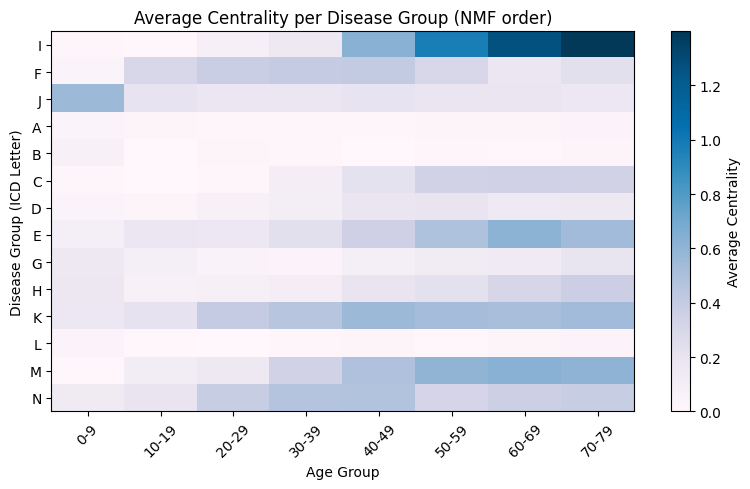

In [56]:
from sklearn.decomposition import NMF

# Compute average centrality per disease group (first letter) for each age group
group_letters = sorted(set([code[0] for code in label_all_code]))
avg_centrality = np.zeros((len(group_letters), cen_f.shape[1]))  # (14, 8)

for i, letter in enumerate(group_letters):
    indices = [idx for idx, code in enumerate(label_all_code) if code[0] == letter]
    if indices:
        avg_centrality[i, :] = cen_f[indices, :].mean(axis=0)

# NMF decomposition (3 components)
n_components = 3
nmf = NMF(n_components=n_components, init='random', random_state=0, max_iter=1000)
W = nmf.fit_transform(np.abs(avg_centrality))
H = nmf.components_
print(W.shape)

# For each component, find the group with the highest loading
top_groups = np.argmax(W, axis=0)
# Get unique order by component (if duplicates, keep order of appearance)
ordered_indices = []
for idx in top_groups:
    if idx not in ordered_indices:
        ordered_indices.append(idx)
# Add remaining groups not in top_groups
for idx in range(len(group_letters)):
    if idx not in ordered_indices:
        ordered_indices.append(idx)

# Plot in the new order
plt.figure(figsize=(8, 5))
im = plt.imshow(avg_centrality[ordered_indices, :], aspect='auto', cmap='PuBu')
plt.colorbar(im, label='Average Centrality')
plt.xticks(ticks=np.arange(len(age_groups)), labels=age_groups, rotation=45)
plt.yticks(ticks=np.arange(len(group_letters)), labels=[group_letters[i] for i in ordered_indices])
plt.xlabel('Age Group')
plt.ylabel('Disease Group (ICD Letter)')
plt.title('Average Centrality per Disease Group (NMF order)')
plt.tight_layout()
plt.show()

In [50]:
df.columns

Index(['r', 'err', 'R2', 'sparsW', 'sparsH', 'silW', 'stability', 'null_means',
       'z_err', 'z_R2', 'z_sparsW', 'z_sparsH', 'z_silW'],
      dtype='object')

In [ ]:
km_labels, km_weights, km = kmeans_soft_weights(X, k=3, method='inverse', random_state=0)

In [89]:
km


,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,0
,copy_x,True
,algorithm,'lloyd'


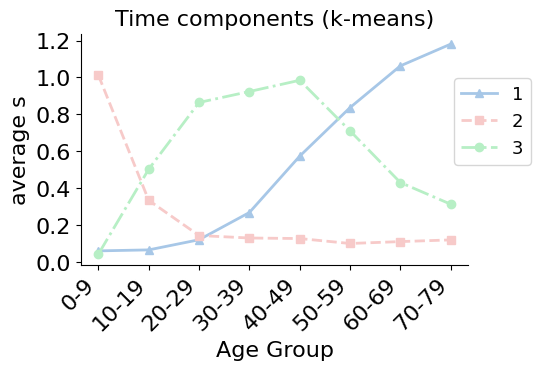

In [85]:
from sklearn.decomposition import PCA

# Plot the evolution of the three clusters (from KMeans) over time (age groups)
# For each cluster, compute the mean value of cen_f_ica_ordered for all ICD codes in that cluster at each age group
labels_age = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
fsize= 6
plt.figure(figsize=(5, 3))
fsize = 16  # or your preferred fontsize
line_styles = ['-', '--', '-.']  # Three different line styles
# Three very soft pastel colors (e.g., light blue, light pink, light green)
colors = ['#A7C7E7', '#F7CAC9', '#B7EFC5']
markers = ['^', 's', 'o'] 

       # Triangle, square, circle markers
for c in range(n_clusters):
    idx = np.where(labels_kmeans == c)[0]
    cluster_mean = cen_nonzero[idx, :].mean(axis=0)
    plt.plot(
        range(1, cen_nonzero.shape[1] + 1),
        cluster_mean,
        label=f'{c+1}',
        linestyle=line_styles[c % len(line_styles)],
        marker=markers[c % len(markers)],
        linewidth=2,
        color=colors[c]
    )
    cluster_mean = cen_nonzero[idx, :].mean(axis=0)
    
plt.xlabel('Age Group', fontsize=fsize)
plt.ylabel('average s', fontsize=fsize)
plt.title('Time components (k-means)', fontsize=fsize)
plt.xticks(
    ticks=np.arange(1, cen_nonzero.shape[1] + 1),
    labels=labels_age,
    rotation=45,
    fontsize=fsize,
    ha='right'
)
plt.yticks(fontsize=fsize)
plt.legend(fontsize=fsize-3, loc='center left', bbox_to_anchor=(0.94, 0.62))
# Remove grid from background
plt.grid(False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('./../Figures/time_components_kmeans.png', dpi=600, bbox_inches='tight')
plt.show()



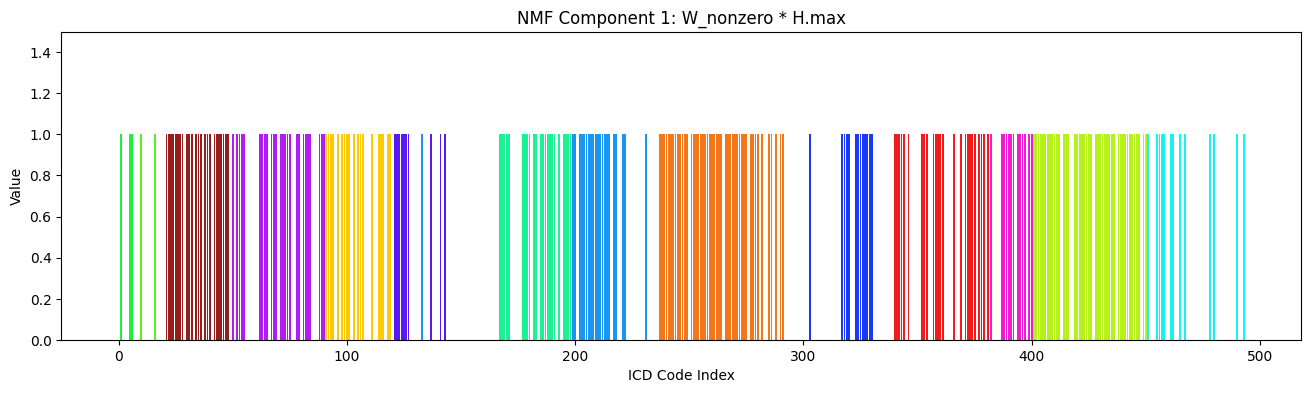

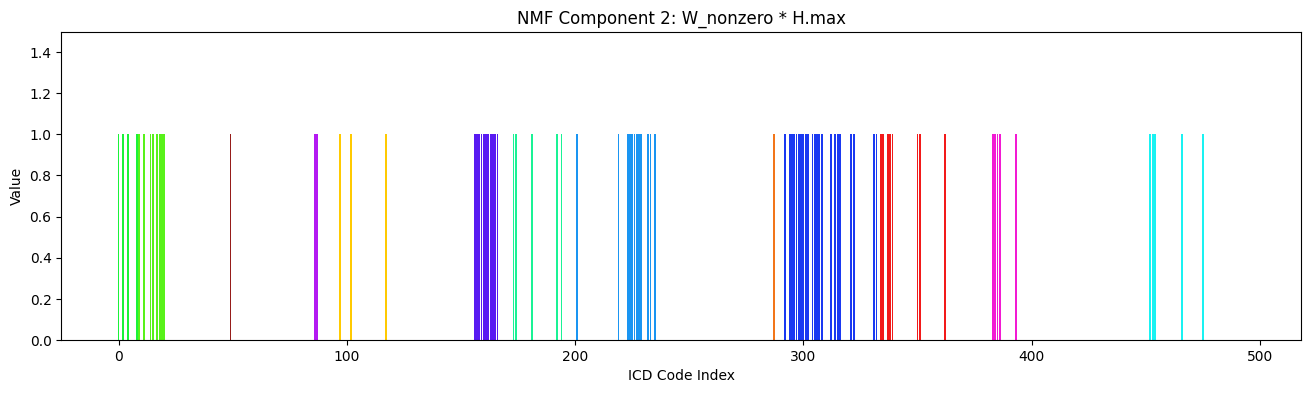

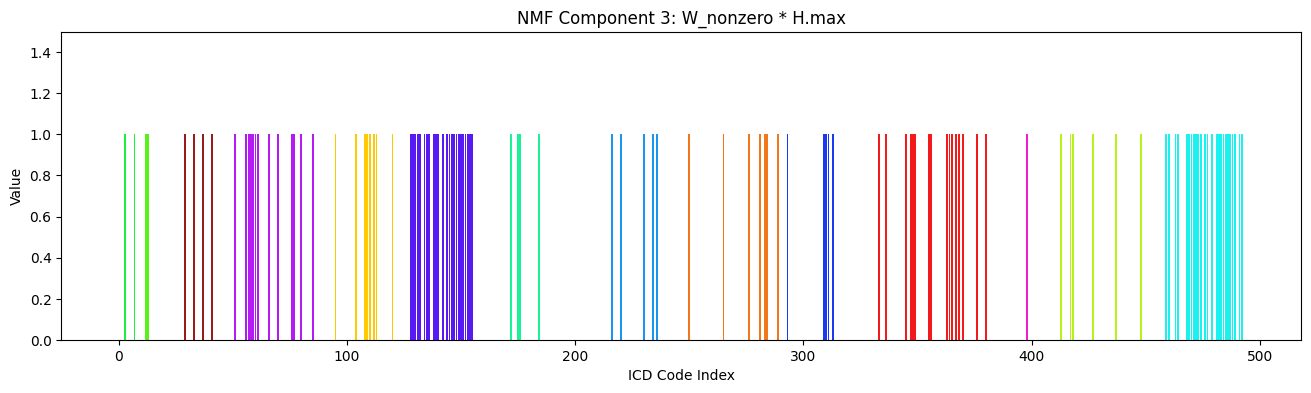

In [87]:
from sklearn.decomposition import NMF

# NMF with 3 components on x_valid vs y_valid (or any matrix, here let's use cen_f_nonzero as in previous context)
n_components = 3
nmf_model = NMF(n_components=n_components, init='random', random_state=0, max_iter=1000)
W_nmf = nmf_model.fit_transform(np.abs(cen_nonzero))
H_nmf = nmf_model.components_



# For each component, plot W_nonzero[:, i] * H_nmf.max() with color by ICD group
for i in range(n_components):
    plt.figure(figsize=(16, 4))
    values = W_nmf[:, i] * H_nmf[i].max()
    values = np.where(labels_kmeans == i, 1, 0)  # Keep only values for cluster i
    # values = km_weights[:,i]
    # Get colors for all bars
    all_colors = [letter_to_hex[labels_nonzero[n][0]] for n in range(len(values))]
    plt.bar(range(len(values)), values, color=all_colors)
    plt.title(f'NMF Component {i+1}: W_nonzero * H.max')
    plt.xlabel('ICD Code Index')
    plt.ylabel('Value')
    plt.ylim([0, 1.5])  # Set y-limits to 10% above max value
    plt.show()

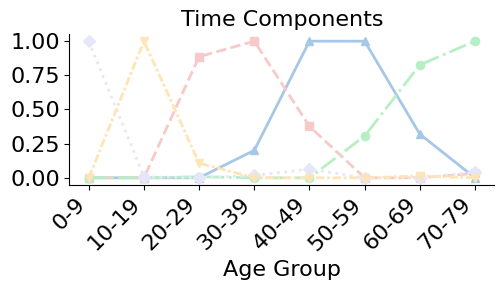

In [100]:
from sklearn.decomposition import NMF

# NMF with 3 components on x_valid vs y_valid (or any matrix, here let's use cen_f_nonzero as in previous context)
n_components = 5
nmf_model = NMF(n_components=n_components, init='random', random_state=0, max_iter=1000)
W_nmf = nmf_model.fit_transform(np.abs(cen_nonzero))
H_nmf = nmf_model.components_

# Plot the three dimensions of H_nmf (NMF components over age groups)
plt.figure(figsize=(5, 3))
fsize = 16
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['#A7C7E7', '#F7CAC9', '#B7EFC5', '#E6E6FA', '#FFE4B5']
markers = ['^', 's', 'o', 'D', 'v']
labels_age = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']

for i in range(H_nmf.shape[0]):
    plt.plot(
        range(1, H_nmf.shape[1] + 1),
        H_nmf[i]/max(H_nmf[i]),  # Normalize each component to its max
        label=f'{i+1}',
        linestyle=line_styles[i % len(line_styles)],
        marker=markers[i % len(markers)],
        linewidth=2,
        color=colors[i % len(colors)]
    )

plt.xlabel('Age Group', fontsize=fsize)
plt.ylabel('', fontsize=fsize)
plt.title('Time Components', fontsize=fsize)
plt.xticks(
    ticks=np.arange(1, H_nmf.shape[1] + 1),
    labels=labels_age,
    rotation=45,
    fontsize=fsize,
    ha='right'
)
plt.yticks(fontsize=fsize)
#plt.legend(fontsize=fsize, loc='center left', bbox_to_anchor=(0.94, 0.62))
plt.grid(False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


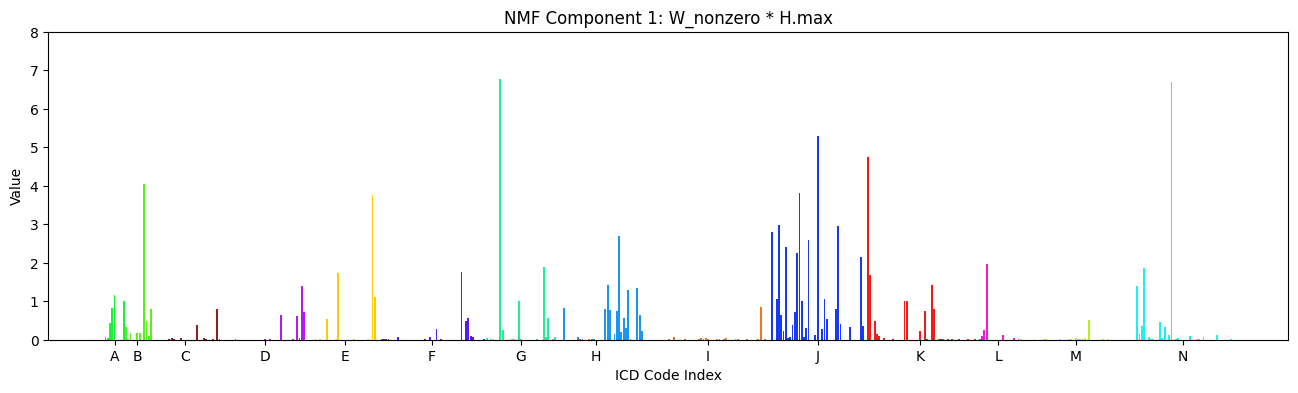

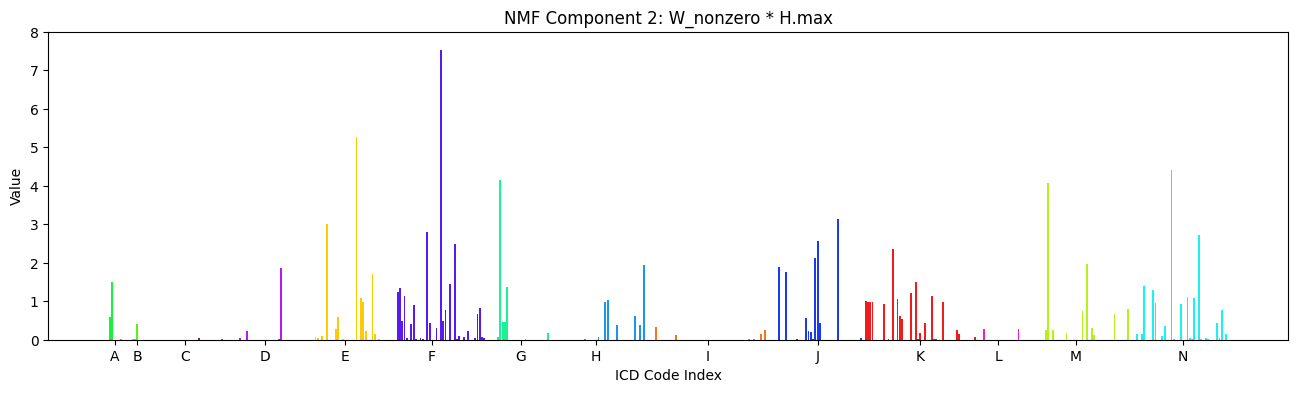

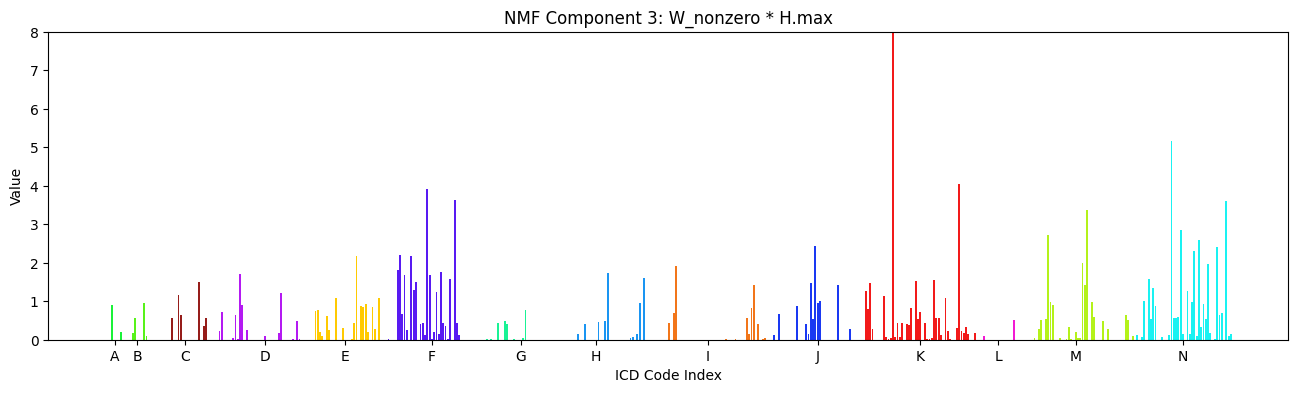

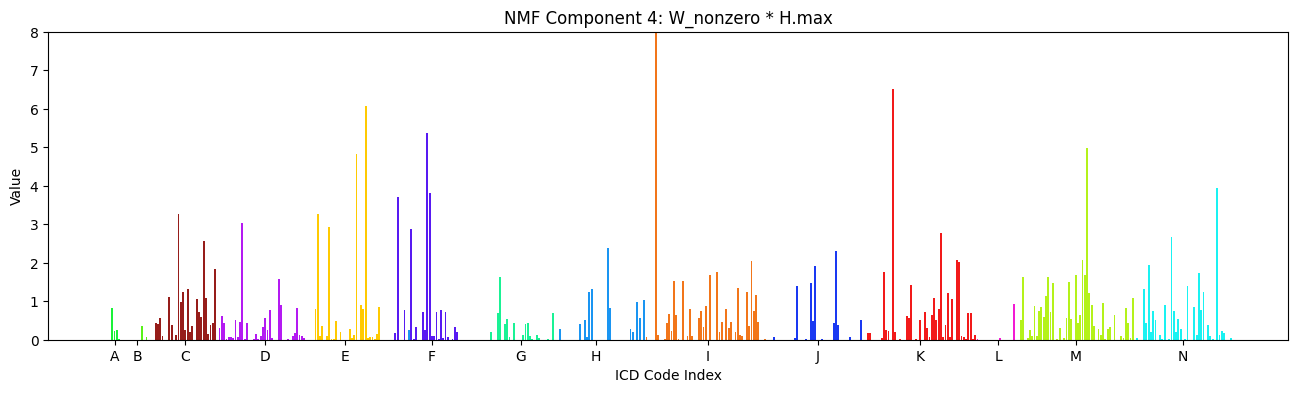

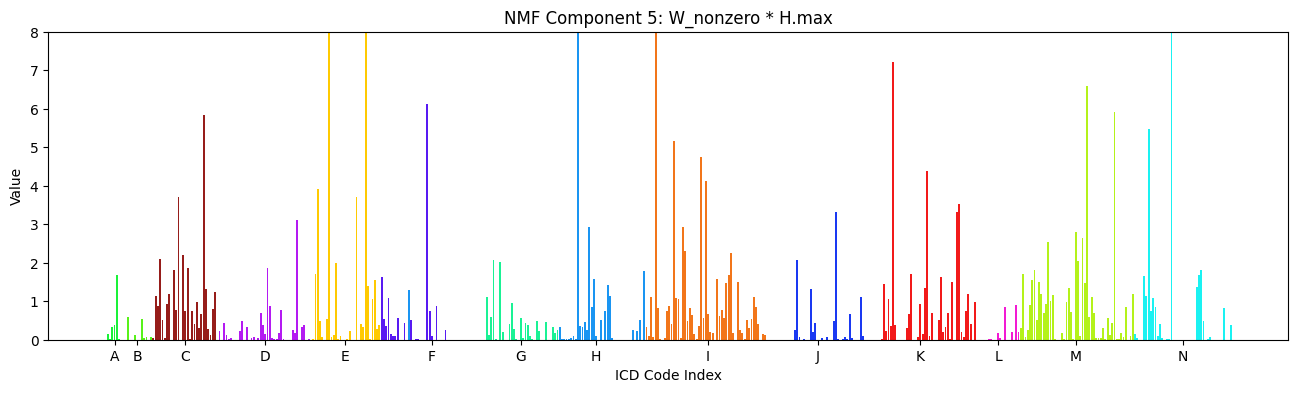

In [101]:
from sklearn.decomposition import NMF

# NMF with 3 components on x_valid vs y_valid (or any matrix, here let's use cen_f_nonzero as in previous context)
n_components = 5
nmf_model = NMF(n_components=n_components, init='random', random_state=0, max_iter=1000)
W_nmf = nmf_model.fit_transform(np.abs(cen_nonzero))
H_nmf = nmf_model.components_
# Indices of H_nmf rows ordered by earliest peak position (tie-breaker: higher peak first)
row_peak_pos = np.argmax(H_nmf, axis=1)
row_peak_height = H_nmf[np.arange(H_nmf.shape[0]), row_peak_pos]
peak_order_rows = list(np.lexsort((-row_peak_height, row_peak_pos)))


# For each component, plot W_nonzero[:, i] * H_nmf.max() with color by ICD group
for n, i in enumerate(peak_order_rows):
    plt.figure(figsize=(16, 4))
    values = W_nmf[:, i] * H_nmf[i].max()
    # values = np.where(labels_kmeans == i, 1, 0)  # Keep only values for cluster i
    # values = km_weights[:,i]
    # Get colors for all bars
    # Put one x tick per color group (ICD first letter)
    letters_seq = [labels_nonzero[n][0] for n in range(len(values))]
    unique_letters = []
    indices_by_letter = {}
    for idx, L in enumerate(letters_seq):
        if L not in indices_by_letter:
            unique_letters.append(L)
            indices_by_letter[L] = []
        indices_by_letter[L].append(idx)
    # Tick at the center of each group's indices
    tick_positions = [int(np.mean(indices_by_letter[L])) for L in unique_letters]
    plt.xticks(tick_positions, unique_letters, rotation=0)
    all_colors = [letter_to_hex[labels_nonzero[n][0]] for n in range(len(values))]
    plt.bar(range(len(values)), values, color=all_colors)
    plt.title(f'NMF Component {n+1}: W_nonzero * H.max')
    plt.xlabel('ICD Code Index')
    plt.ylabel('Value')
    plt.ylim([0, 8])  # Set y-limits to 10% above max value
    plt.show()

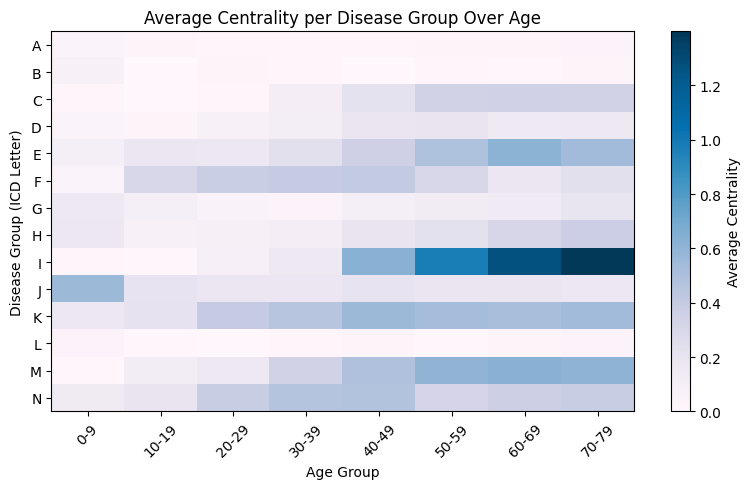

In [ ]:
# Compute average centrality per disease group (first letter) for each age group
color_map = plt.cm.PuBu  # pastel blue colormap

group_letters = sorted(set([code[0] for code in label_all_code]))
group_to_idx = {letter: idx for idx, letter in enumerate(group_letters)}
avg_centrality = np.zeros((len(group_letters), cen_f.shape[1]))  # (14, 8)
order_ = np.argsort(avg_centrality[:,-1])
for i, letter in enumerate(group_letters):
    indices = [idx for idx, code in enumerate(label_all_code) if code[0] == letter]
    if indices:
        avg_centrality[i, :] = cen_f[indices, :].mean(axis=0)

plt.figure(figsize=(8, 5))
im = plt.imshow(avg_centrality[order_,:], aspect='auto', cmap=color_map)
plt.colorbar(im, label='Average Centrality')
plt.xticks(ticks=np.arange(len(age_groups)), labels=age_groups, rotation=45)
plt.yticks(ticks=np.arange(len(group_letters)), labels=group_letters)
plt.xlabel('Age Group')
plt.ylabel('Disease Group (ICD Letter)')
plt.title('Average Centrality per Disease Group Over Age')
plt.tight_layout()
plt.show()